### Imports

In [3]:
import numpy as np
import torch
import seaborn as sns
import random
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from scipy import stats
import copy
import glob
import os
import pickle
from invoke import run

In [4]:
#model = torch.load('/checkpoint/dieuwkehupkes/mt-data/en-nl/opus-taboeta/checkpoints/base_all_1/checkpoint_best.pt')

### Global Attention Metric

In [5]:
def flatten(t):
    return [item for sublist in t for item in sublist]

def get_positions_distances_mat(length, negative=False):
    '''
    For length 4:
    distance matrix = [[1,2,3,4],[2,1,2,3],[3,2,1,2],[4,3,2,1]]
    '''
    
    distances_matrix = np.zeros((length,length))
    tri = flatten([list(np.arange(i)+1) for i in range(length-1,0,-1)])
    distances_matrix[np.triu_indices(length,1)] = tri
    if not negative:
        distances_matrix += distances_matrix.T
    else:
        distances_matrix -= distances_matrix.T
    
    if not negative: 
        return torch.tensor(distances_matrix)# + 1
    else:
        return torch.tensor(distances_matrix)
    
print(get_positions_distances_mat(4))
print(get_positions_distances_mat(4,True))

tensor([[0., 1., 2., 3.],
        [1., 0., 1., 2.],
        [2., 1., 0., 1.],
        [3., 2., 1., 0.]], dtype=torch.float64)
tensor([[ 0.,  1.,  2.,  3.],
        [-1.,  0.,  1.,  2.],
        [-2., -1.,  0.,  1.],
        [-3., -2., -1.,  0.]], dtype=torch.float64)


In [6]:
def calc_global_metric(attn_mat):
    '''
    Calculate a metric to estimate how much a given attntion head is global in thier weights.
    For a given head, the calculation is a mean weighted sum for every token.
    The score for token in position i = sum_{for every token in position j}(a/num_of_tokens)
    
    A score of 1.0 is completely global, a score of 1/num_of_tokens is completely local.
    '''
    
    cur_max_position = attn_mat.shape[-1] # maximal number of tokens
    distances_matrix = get_positions_distances_mat(cur_max_position).to(attn_mat.device) # global weights, the higher the more global
    
    # normlize weights to sum to 1.0, in case they don't (in remove EOS)
    norm_attn_mat = attn_mat / attn_mat.sum(dim=1).unsqueeze(1).expand(attn_mat.shape)
    
    sum_mat = torch.sum(distances_matrix*norm_attn_mat,axis=len(norm_attn_mat.shape)-1)
    normalized_weight_distanced = sum_mat / (cur_max_position + 1) # normlize score according to length so max is 1
    
    return normalized_weight_distanced.mean(-1)
    

## Attention Matrix Processing

#### Create Avg Matrix for a range of samples

In [7]:
def get_batch_sample_attn_matrix_load(sample_num, model_attn_dir):
    '''Stack attn_matrix of all layers to a single matrix that belong to one sample'''
    sample_attn_matrix = torch.zeros(NUM_LAYERS,NUM_HEADS,MAX_POSITION,MAX_POSITION)
    layers_matricies = []
    
    if torch.load(model_attn_dir + f'/batch_sample_attn_mat_0.pt').shape[0] == 8: # batch size 1
        for i in range(NUM_LAYERS):
            cur_index = sample_num*NUM_LAYERS + i
            layers_matricies.append(torch.load(model_attn_dir + f'/batch_sample_attn_mat_{cur_index}.pt'))
        sample_mat = torch.stack(layers_matricies, dim=0)
    else: # batch size is 128
        batch_size = int(torch.load(model_attn_dir + f'/batch_sample_attn_mat_0.pt').shape[0]/NUM_HEADS)
        print(f"batch_size={batch_size}")
        for i in range(NUM_LAYERS):
            cur_index = int(sample_num / batch_size)*NUM_LAYERS + i
            print(f"cur_index={cur_index}")
            loaded_mat = torch.load(model_attn_dir + f'/batch_sample_attn_mat_{cur_index}.pt')
            print("sample_attn_mat_ shape:",loaded_mat.shape)
            
            index_in_matrix = (sample_num % batch_size)*NUM_HEADS
            print(f"index_in_matrix={index_in_matrix}")
            layers_matricies.append(loaded_mat[index_in_matrix:index_in_matrix+NUM_HEADS,:,:])
#             indexes_in_matrix = list(range(sample_num % batch_size,NUM_HEADS*batch_size,batch_size))
#             print(f"indexes_in_matrix={indexes_in_matrix}")
#             layers_matricies.append(loaded_mat[indexes_in_matrix,:,:])
            
        sample_mat = torch.stack(layers_matricies, dim=0)
        print(f"sample_mat.shape[-1]={sample_mat.shape[-1]}")
    
    sample_attn_matrix[:,:,:sample_mat.shape[-1],:sample_mat.shape[-1]] = sample_mat
    
    #return sample_attn_matrix
    return layers_matricies

# def get_sample_attn_matrix_load(sample_num, model_attn_dir):
#     '''Stack attn_matrix of all layers to a single matrix that belong to one sample'''
#     sample_attn_matrix = torch.zeros(NUM_LAYERS,NUM_HEADS,MAX_POSITION,MAX_POSITION)
#     layers_matricies = []
    
#     batch_size_times_heads = get_batch_size_times_heads(model_attn_dir)
    
#     if batch_size_times_heads == NUM_HEADS: # batch size 1
#         for i in range(NUM_LAYERS):
#             cur_index = sample_num*NUM_LAYERS + i
#             #print(f"cur_index={cur_index}")
#             #print("sample_attn_mat_ shape:",torch.load(model_attn_dir + f'/sample_attn_mat_{cur_index}.pt').shape)
#             layers_matricies.append(torch.load(model_attn_dir + f'/sample_attn_mat_{cur_index}.pt'))
#         sample_mat = torch.stack(layers_matricies, dim=0)
#         #print(f"sample_mat.shape[-1]={sample_mat.shape[-1]}")
    
#     sample_attn_matrix[:,:,:sample_mat.shape[-1],:sample_mat.shape[-1]] = sample_mat
    
#     return sample_attn_matrix
    #return layers_matricies

In [8]:
def get_sample_attn_matrix_load(sample_num, model_attn_dir):
    '''Stack attn_matrix of all layers to a single matrix that belong to one sample'''
    sample_attn_matrix = torch.zeros(NUM_LAYERS,NUM_HEADS,MAX_POSITION,MAX_POSITION)
    layers_matricies = []
    
    batch_size_times_heads = get_batch_size_times_heads(model_attn_dir)
    if batch_size_times_heads == NUM_HEADS: # batch size 1
        #print("batch size 1")
        for i in range(NUM_LAYERS):
            cur_index = sample_num*NUM_LAYERS + i
            layers_matricies.append(torch.load(model_attn_dir + f'/sample_attn_mat_{cur_index}.pt'))
        sample_mat = torch.stack(layers_matricies, dim=0)
    else: # batch size is 128
        batch_size = int(torch.load(model_attn_dir + f'/sample_attn_mat_0.pt').shape[0]/NUM_HEADS)
        #print(f"batch_size={batch_size}")
        for i in range(NUM_LAYERS):
            cur_index = int(sample_num / batch_size)*NUM_LAYERS + i
            #print(f"cur_index={cur_index}")
            loaded_mat = torch.load(model_attn_dir + f'/sample_attn_mat_{cur_index}.pt')
            index_in_matrix = (sample_num % batch_size)*NUM_HEADS
            #print(f"index_in_matrix={index_in_matrix}")
            layers_matricies.append(loaded_mat[index_in_matrix:index_in_matrix+NUM_HEADS,:,:])
        sample_mat = torch.stack(layers_matricies, dim=0)
        #print(f"sample_mat.shape[-1]={sample_mat.shape[-1]}")
    
    sample_attn_matrix[:,:,:sample_mat.shape[-1],:sample_mat.shape[-1]] = sample_mat
    
    return sample_attn_matrix

def get_batch_size_times_heads(model_attn_dir):
    try:
        sample_matrix = torch.load(model_attn_dir + f'/sample_attn_mat_0.pt')
        batch_size_times_heads = sample_matrix.shape[0]
    except Exception as e:
        list_of_files = glob.glob(f'{model_attn_dir}/avg_attn_mat*') 
        latest_avg_matrix = max(list_of_files, key=os.path.getctime)
        #batch_size_times_heads = int(latest_avg_matrix.split('avg_attn_mat_')[1][:2].replace('_','')) # get the length from the avg mat file name
        sample_matrix = torch.load(latest_avg_matrix)
        batch_size_times_heads = sample_matrix.shape[1]
    return batch_size_times_heads

def delete_sample_range_attn_mat(model_attn_dir,samples_range):
    batch_size_times_heads = get_batch_size_times_heads(model_attn_dir)
    for sample_num in range(samples_range[0], samples_range[1]+1):
        #print(f"Trying to delete: {sample_num} {model_attn_dir} batch_size_times_heads={batch_size_times_heads} NUM_HEADS={NUM_HEADS}")
        if batch_size_times_heads == NUM_HEADS: # batch size 1
            for i in range(NUM_LAYERS):
                cur_index = sample_num*NUM_LAYERS + i
                #print(f"Trying to delete cur_index: {model_attn_dir}/sample_attn_mat_{cur_index}.pt")
                if os.path.exists(f'{model_attn_dir}/sample_attn_mat_{cur_index}.pt'):
                    #print(f"deleteing... {model_attn_dir}/sample_attn_mat_{cur_index}.pt")
                    os.remove(f'{model_attn_dir}/sample_attn_mat_{cur_index}.pt')
           
        
def get_avg_attn_matrix_load(samples_range, length, NUM_SAMPLES, model_attn_dir, size, cond, cond_name, text_type,recompte_avg_attn_mat=False):
    range_name = str(samples_range).replace(' ','_')
    saving_name = model_attn_dir + f'/avg_attn_mat_{length}_{range_name}_{size}_{cond}_{cond_name}_{text_type}.pt'
    if not recompte_avg_attn_mat:
        try:
            #print(f"Trying to load: {saving_name}")
            res = torch.load(saving_name)
            # print(f"Using saved avg matrix at {saving_name}")
            # delete_sample_range_attn_mat(model_attn_dir,samples_range)
            return res
        except Exception as e:
            print(f"Exception is:{e}")
            print("No saved avg matrix, calculating and saving")
    print(f"Computing avg matrix for {saving_name}...")

    sum_attn_weights = torch.zeros((NUM_LAYERS,NUM_HEADS,MAX_POSITION,MAX_POSITION)) # layers X attn_heads X max_position X max_position
    devision_matrix = torch.zeros((NUM_LAYERS,NUM_HEADS,MAX_POSITION,MAX_POSITION)) # layers X attn_heads X max_position X max_position

    # print(f"Sample Range:{samples_range}")
    for sample_num in range(samples_range[0], samples_range[1]+1):
        # print(f"sample_num:{sample_num}")
        sample_attn_matrix = get_sample_attn_matrix_load(sample_num, model_attn_dir)

#         if sample_num < samples_range[0]:
#             continue
#         #print(f"{sample_num}", end=",")
#         if sample_num > samples_range[1]:
#             break

        sum_attn_weights += sample_attn_matrix
        devision_matrix[sample_attn_matrix!=0] += 1

    devision_matrix[devision_matrix==0] = 1
    res = sum_attn_weights/devision_matrix
    
    torch.save(res, saving_name)
    print(f"Saved avg matrix at {saving_name}")
    # delete_sample_range_attn_mat(model_attn_dir,samples_range)
    return res

def is_eos_focused(sample_attn_matrix):
    weight_threshold = 0.20 # 2*1/LENGTH
    majority_threshold = 0.80
    eos_above_threshold = torch.sum(sample_attn_matrix[:,-1] > weight_threshold)
    return (eos_above_threshold / sample_attn_matrix.shape[-1]) > majority_threshold
    

def get_avg_attn_matrix_across_heads(samples_heads_list, LENGTH, model_attn_dir, ignore_eos=False):
    sum_attn_weights = torch.zeros((LENGTH,LENGTH)) 
    devision_matrix = torch.zeros((LENGTH,LENGTH)) 

    for score,sample_num,layer,head in samples_heads_list:
        sample_attn_matrix = get_sample_attn_matrix_load(sample_num, model_attn_dir)
        #print(f"sample_attn_matrix.shape:{sample_attn_matrix.shape}")
        sample_attn_matrix = sample_attn_matrix[layer][head][:LENGTH,:LENGTH]
        #print(f"sample_attn_matrix.shape:{sample_attn_matrix.shape}")
        #print(f"sum_attn_weights.shape:{sum_attn_weights.shape}")
        if ignore_eos and is_eos_focused(sample_attn_matrix):
            continue
        sum_attn_weights += sample_attn_matrix
        devision_matrix[sample_attn_matrix!=0] += 1
    
    print(f"Number of matrices averaged upon: {devision_matrix[0][0]}")
    
    devision_matrix[devision_matrix==0] = 1
    return sum_attn_weights/devision_matrix

#### Util Functions

In [9]:
def get_samples_from_prints():
    all_samples = dict()
    with open(fname, 'r') as f:
        sample_num = 0
        line = f.readline()
        while len(line) != 0: # not EOF
            if '</s>' in line:
                all_samples[sample_num] = line
                #print(str(sample_num)+line)
                sample_num += 1
            line = f.readline()
    return all_samples
                            
def get_all_samples_dict(fname):
    if "attn_weights2.txt" in fname:
        print("getting samples dict from: attn_weights2.txt")
        return get_samples_from_prints()
    print(f"getting samples dict from: {fname}")
    all_samples = dict()
    with open(fname, 'r') as f:
        sample_num = 0
        line = f.readline()
        while len(line) != 0: # not EOF
            if 'S-' in line:
                all_samples[sample_num] = line.split(' ')#[1:]
                #print(str(sample_num)+line)
                sample_num += 1
            line = f.readline()
    return all_samples

def get_sample_len(sample_num, model_attn_dir, num_of_samples):
    try:
        sample_matrix = torch.load(model_attn_dir + f'/sample_attn_mat_{sample_num}.pt')
    except Exception as e: # there's exists a saved lengths dict
        lengths_dict = get_samples_lengths_dict(num_of_samples, model_attn_dir)
        
        for length in lengths_dict.keys():
            loading_name = f'{model_attn_dir}/{length}_range_tuple.pt'
            loaded_range = torch.load(loading_name)
            if (loaded_range[length][0] <= sample_num) or (sample_num <= loaded_range[length][1]):
                return length
    
    if sample_matrix.shape[0] == 8: # batch size 1
        index = sample_num*NUM_LAYERS
    else: # batch size 128
        batch_size = int(torch.load(model_attn_dir + f'/sample_attn_mat_{sample_num}.pt').shape[0]/NUM_HEADS)
        index = int(sample_num / batch_size)*NUM_LAYERS 
    attn_mat = torch.load(model_attn_dir+f'/sample_attn_mat_{index}.pt')
    return attn_mat.shape[-1]

def display_sample(LAYER, HEAD, sample_num, all_samples, model_attn_dir, print_out=True):
    sample_attn_matrix = get_sample_attn_matrix_load(sample_num, model_attn_dir)
    sample, sample_len = all_samples[sample_num].copy(), get_sample_len(sample_num, model_attn_dir, len(all_samples))
    
    sample[0] = sample[0].split('\t')[1]
    sample[-1] = '.'
    sample.append('EOS')


    gm_score = calc_global_metric(sample_attn_matrix[LAYER][HEAD][:sample_len,:sample_len]).item()
    w_median = get_mean_distance_weighted_median(sample_attn_matrix[LAYER][HEAD][:sample_len,:sample_len])
    
    if print_out:
        print(' '.join(sample))
        print(f"LAYER={LAYER}, HEAD={HEAD}")
        ax = sns.heatmap(sample_attn_matrix[LAYER][HEAD][:sample_len,:sample_len], xticklabels=sample, yticklabels=sample)
 
        ax.set(title="Attention Heatmap",
          xlabel="Attention To",
          ylabel="Attention From",)
        
        plt.rcParams["figure.figsize"] = (6,4.5)
        plt.show()
        print("Global Metric = {:.2f}".format(gm_score))
        print("Weighted Median = {:.2f}".format(w_median))
    
    return gm_score, w_median 
    
def get_samples_lengths_dict(num_of_samples, model_attn_dir):
    saving_name = f'{model_attn_dir}/lengths_dict.pt'
    if os.path.exists(saving_name):
        print(f"Loading lengths_dict from: {model_attn_dir}")
        return torch.load(saving_name)
                          
    print(f"Creating new lengths_dict for: {model_attn_dir}")
    samples_legnth = dict()
    for sample_num in range(num_of_samples):
        cur_len = get_sample_len(sample_num, model_attn_dir, num_of_samples)
        if cur_len in samples_legnth:
            samples_legnth[cur_len] += 1
        else:
            samples_legnth[cur_len] = 1
                          
    torch.save(samples_legnth,saving_name)
    return samples_legnth

    
def get_samples_range(target_length, num_of_samples, model_attn_dir):
    saving_name = f'{model_attn_dir}/{target_length}_range_tuple.pt'
    if os.path.exists(saving_name):
        return torch.load(saving_name)[target_length]
    
    samples_cur_legnth = []
    for sample_num in range(num_of_samples):
        cur_len = get_sample_len(sample_num, model_attn_dir, num_of_samples)    
        #print(f"sample_num:{sample_num} | cur_len:{cur_len}")
        if cur_len == target_length:
            samples_cur_legnth.append(sample_num)
    if len(samples_cur_legnth) == 0:
        raise Exception(f'No samples found with length {target_length} for model at {model_attn_dir}.')
    res = {target_length: (samples_cur_legnth[0],samples_cur_legnth[-1])}
    torch.save(res, saving_name)
    return res[target_length]

def get_bleu_score(trained_model, size):
    list_of_files = glob.glob(f'/checkpoint/itayitzhak/trained_models/opus/{size}/{trained_model}/eval*out*') 
    latest_file = max(list_of_files, key=os.path.getctime)
    with open(latest_file, 'r') as f:
        for line in f.readlines():
            if 'BLEU4' in line:
                return float(line.split('BLEU4')[1][3:8].strip().replace(',',''))
    return None

In [10]:
def weighted_median(data, weights):
    """
    Args:
      data (list or numpy.array): data
      weights (list or numpy.array): weights
    
    returns the weighted median in data according to weights (float)
    """
    data, weights = np.array(data).squeeze(), np.array(weights).squeeze()
    s_data, s_weights = map(np.array, zip(*sorted(zip(data, weights))))
    midpoint = 0.5 * sum(s_weights)
    if any(weights > midpoint):
        w_median = (data[weights == np.max(weights)])[0]
    else:
        cs_weights = np.cumsum(s_weights)
        idx = np.where(cs_weights <= midpoint)[0][-1]
        if cs_weights[idx] == midpoint:
            w_median = np.mean(s_data[idx:idx+2])
        else:
            w_median = s_data[idx+1]
    return w_median
    
def get_mean_distance_weighted_median(attn_mat):
    num_of_tokens = attn_mat.shape[0]
    dists = get_positions_distances_mat(num_of_tokens,negative=True)
    #sum_of_weighted_medians = 0
    all_weighted_medians = []
    for index_token in range(num_of_tokens):
        cur_weighted_median = weighted_median(dists[index_token], attn_mat[index_token]/sum(attn_mat[index_token])) # scale weights to sum to 1.0 if they are not (in remove EOS)
        # sum_of_weighted_medians += abs(cur_weighted_median)
        all_weighted_medians.append(abs(cur_weighted_median))
    return np.percentile(all_weighted_medians, 90)

#print(weighted_median([2,1,0,1,2,3],[0.12,0.01,0.01,0.01,0.0,0.85])) # 3
#print(weighted_median([2,1,0,1,2,3],[0.5,0.01,0.01,0.01,0.0,0.47])) # 2
#print(weighted_median([2,1,0,1,2],[0.9,0.01,0.01,0.01,0.07])) # 2
#print(weighted_median([2,1,0,1,2],[0.5,0.01,0.01,0.01,0.47])) # 2
#print(weighted_median([2,1,0,1,2],[0.01,0.5,0.01,0.01,0.47])) # 1
#print(weighted_median([2,1,0,1,2],[0.01,0.5,0.01,0.47,0.01])) # 1
#print(weighted_median([2,1,0,1,2],[0.01,0.01,0.5,0.47,0.01])) # 0.5
#get_mean_distance_weighted_median(torch.tensor([[0.5,0.5,0.0],[0.1,0.8,0.1],[0.95,0.05,0.05]]))

In [39]:
def get_model_wmd_gloablity_scores(attn_mat, LENGTH, with_eos=True):
    distance_weighted_median = []
    globality_scores = []
    for i in range(NUM_LAYERS):
        for j in range(NUM_HEADS):
            cur_head = attn_mat[i][j][:LENGTH,:LENGTH]
            if not with_eos:
                cur_head = cur_head[:-1,:-1]
            distance_weighted_median.append(get_mean_distance_weighted_median(cur_head))
            globality_scores.append(calc_global_metric(cur_head).item())
    
    model_distance_weighted_median = sum(distance_weighted_median)/len(distance_weighted_median)
    model_globality_scores = sum(globality_scores)/len(globality_scores)
    return model_globality_scores, model_distance_weighted_median
    

def calc_percentage_of_attn_head_type(attn_mat, LENGTH, with_eos, weight_threshold=0.35, majority_threshold=0.9):
#     print(f"Attention Weight threshold is: {weight_threshold:.2f}.")
#     print(f"Majority threshold is: {majority_threshold:.1f}.")
    num_of_eos_foucesed_heads = 0
    num_of_local_heads = 0
    num_of_self_heads = 0
    
    eos_foucesed_heads = []
    self_heads = []
    local_heads = []
    distance_weighted_median = []
    globality_scores = []
    
    for i in range(NUM_LAYERS):
        for j in range(NUM_HEADS):
            cur_head = attn_mat[i][j][:LENGTH,:LENGTH]
            if not with_eos:
                cur_head = cur_head[:-1,:-1]
            
            # EOS-focused
            eos_foucesed_heads.append(np.percentile(cur_head[:,-1], 90))
            eos_above_threshold = torch.sum(cur_head[:,-1] > weight_threshold)
            #eos_foucesed_heads.append(torch.mean(cur_head[:,-1]))
            if (eos_above_threshold / cur_head.shape[-1]) > majority_threshold:
                num_of_eos_foucesed_heads += 1
                
            # Self-focused
            #print(sorted([x.item() for x in cur_head.diagonal()]))
            self_heads.append(np.percentile(cur_head.diagonal(), 90))
            self_above_threshold = torch.sum(cur_head.diagonal() > weight_threshold)
            if (self_above_threshold / cur_head.shape[-1]) > majority_threshold:
                num_of_self_heads += 1
                
            # Local-focused
            local_mean = (cur_head.diagonal()[1:-1] + cur_head.diagonal(1)[1:] + cur_head.diagonal(-1)[:-1])#/3
            pos_first_local_mean = (cur_head.diagonal()[0] + cur_head.diagonal(1)[0]) #/ 2
            pos_last_local_mean = (cur_head.diagonal()[-1] + cur_head.diagonal(-1)[-1]) #/ 2
            local_mean = torch.cat([pos_first_local_mean.unsqueeze(0),local_mean,pos_last_local_mean.unsqueeze(0)])
            
            local_mean -= cur_head.diagonal() # do not include self attention
            
            local_heads.append(np.percentile(local_mean, 90))
            local_above_threshold = torch.sum(cur_head.diagonal() > weight_threshold)
            if (local_above_threshold / cur_head.shape[-1]) > majority_threshold:
                num_of_local_heads += 1
            
            # Weighted median distance & Globality
            distance_weighted_median.append(get_mean_distance_weighted_median(cur_head))
            globality_scores.append(calc_global_metric(cur_head).item())

    print("Percentage of EOS focused heads:  {:.2%}".format(num_of_eos_foucesed_heads/(NUM_LAYERS*NUM_LAYERS)), end=' | ')
    print("Percentage of self focused heads: {:.2%}".format(num_of_self_heads/(NUM_LAYERS*NUM_LAYERS)), end=' | ')
    print("Percentage of Local focused heads: {:.2%}".format(num_of_local_heads/(NUM_LAYERS*NUM_LAYERS)))
    
    return eos_foucesed_heads, self_heads, local_heads, distance_weighted_median, globality_scores
    

## Analysis

#### Compare sampels from different model evaluation

In [12]:
# LAYER = 5
# HEAD = 0
# sample_num = 100

# seed_mod = '1'
# seed_data = '1'
# size = 'all' # 'all'
# cond = 's_conj' #'s_np_vp'
# cond_name = 's1_s2'#'np'
# data_type = 'synthetic' #'semi_natural' #'natural'
# premuted_prefix = 'compositional_mt_'#'permuted_data_' # ''
# premuted_suffix = ''#'_3gram' # ''
# LENGTH = 17
# NUM_HEADS = 8\\
# NUM_LAYERS = 6
# MAX_POSITION = 1024
# #############################
# cur_model_path = f'/checkpoint/itayitzhak/attn_weigths/{premuted_prefix}systematicity_{cond}_{data_type}_systematicity_{data_type}_{seed_data}_{cond_name}{premuted_suffix}_{size}'
# #cur_model_pred = f'/checkpoint/itayitzhak/attn_weigths/systematicity_s_conj_synthetic_systematicity_synthetic_1_s1_s2_all/generate-test.txt'
# cur_model_pred = f'/checkpoint/itayitzhak/attn_weigths/compositional_mt_systematicity_{cond}_{data_type}_systematicity_{data_type}_{seed_data}_{cond_name}_all/generate-test.txt'
# if 'permuted' in premuted_prefix:
#     cur_model_pred = f'/checkpoint/itayitzhak/permuted_data/systematicity/{cond}/{data_type}/systematicity_{data_type}_{seed_data}_{cond_name}{premuted_suffix}/all/pred.txt/generate-test.txt'
# all_samples = get_all_samples_dict(cur_model_pred)

# NUM_SAMPLES = len(all_samples)

# Per sample
# display_sample(LAYER, HEAD, sample_num, all_samples, cur_model_path)
# #bla = cur_model_path.split('/')[-1]
# print(f"Model:{cur_model_path}")
# print(f"Predi:{cur_model_pred}")

In [13]:
# Per layer
# LAYER = 4
#sns.heatmap(avg_attn_matrix[LAYER].mean(dim=0)[:LENGTH,:LENGTH])

In [14]:
# Per head
# LAYER = 4
# HEAD = 7
# sns.heatmap(avg_attn_matrix[LAYER][HEAD][:LENGTH,:LENGTH])
# print("Global Metric = {:.2f}".format(calc_global_metric(avg_attn_matrix[LAYER][HEAD][:LENGTH,:LENGTH]).item()))

### Compute Consistency

In [52]:
import logging
import pickle
import numpy as np
import editdistance


def get_conjunct(sentence):
    """
    Separate sentence into two parts based on conjunction.
    Args:
        - sentence (str)
    Returns:
        - whether the conjunct was found
        - the conjunct
    """
    conjunction = " en "

    # If conjunct in sentence
    if conjunction in sentence:
        conjunct = sentence.split(conjunction)[1:]
        # If the conjunct is shorter than 3 words you've got the wrong one
        if len(sentence.split(conjunction)[0].split()) < 3:
            conjunct = sentence.split(conjunction)[2:]
        conjunct = conjunction.join(conjunct)
        return True, f"MASK {conjunct}"
    return False, f"MASK {sentence}"


def reorder(lines):
    """
    Reorder lines, since Fairseq shuffles them while translating.
    Order based on the index indicated after "D-...", "S-..." or "H-...".
    
    Args:
        - lines: list of str
    Returns:
        - list of str
    """
    sentences = []
    for line in lines:
        line = line.split("\t")
        if "D-" in line[0]:
            index = int(line[0].split('-')[1])
            sentence = line[2].strip()
            sentences.append((index, sentence))
    _, sentences = zip(*sorted(sentences))
    assert len(sentences) == 500
    return sentences


def compute_systematicity_s_conj_globality(template, seed, expirement_data_type, text_type, data_size):
    """
    Compute systematicity consistency scores for the S -> S CONJ S setup.
    Args:
        - template (int): 1 ... 10
        - data_type (str): natural | semi_natural | synthetic
        - model (str): format of "transformer_DATA_SEED"
    Returns:
        - s1p (float): consistency score for the S1 -> S1' condition
        - s3 (float): consistency score for the S1 -> S3 condition
        - trace (dict): mistakes made by the model
    """
    trace = dict()
    condition_s1p = []
    condition_s3 = []
    #prefix = f"s_conj/{data_type}/systematicity_{data_type}_{template}"
    home_dir = '/checkpoint/itayitzhak/attn_weigths/'
    source_file_prefix = f'/private/home/dieuwkehupkes/nmt/compositional_mt/systematicity/s_conj/{text_type}/systematicity_{text_type}_{template}'

    # English source sentences
#     with open(f"{prefix}_s1_s2.en", encoding="utf-8") as f:
#         srcs = f.readlines()
    with open(f"{source_file_prefix}_s1_s2.en", encoding="utf-8") as f:
        srcs = f.readlines()
    
    # Gather the translation of the regular setup and the two subconditions
    # prefix = f"s_conj/pred_{data_type}/{model}/systematicity_{data_type}_{template}"
    #with open(f"{prefix}_s1_s2.nl", encoding="utf-8") as f:
    try:
        with open(f"{home_dir}{expirement_data_type}_seed_{seed}_compositional_mt_systematicity_s_conj_{text_type}_systematicity_{text_type}_{template}_s1_s2_{data_size}/generate-test.txt", encoding="utf-8") as f:
            pred_s1_s2 = reorder(f.readlines())
    except Exception as e:
        raise Exception("Could not load pred_s1_s2 at {{home_dir}{expirement_data_type}_seed_{seed}_compositional_mt_systematicity_s_conj_{text_type}_systematicity_{text_type}_{template}_s1_s2_{data_size}/generate-test.txt}\n"+str(e))
    
    try:
        #with open(f"{prefix}_s1p_s2.nl", encoding="utf-8") as f:
        with open(f"{home_dir}{expirement_data_type}_seed_{seed}_compositional_mt_systematicity_s_conj_{text_type}_systematicity_{text_type}_{template}_s1p_s2_{data_size}/generate-test.txt", encoding="utf-8") as f:
            pred_s1p_s2 = reorder(f.readlines())
    except Exception as e:
        raise Exception("Could not load pred_s1p_s2 at {{home_dir}{expirement_data_type}_seed_{seed}_compositional_mt_systematicity_s_conj_{text_type}_systematicity_{text_type}_{template}_s1p_s2_{data_size}/generate-test.txt}\n"+str(e))
        
    try:
        #with open(f"{prefix}_s3_s2.nl", encoding="utf-8") as f:
        with open(f"{home_dir}{expirement_data_type}_seed_{seed}_compositional_mt_systematicity_s_conj_{text_type}_systematicity_{text_type}_{template}_s3_s2_{data_size}/generate-test.txt", encoding="utf-8") as f:
            pred_s3_s2 = reorder(f.readlines())
    except Exception as e:
        raise Exception("Could not load pred_s3_s2 at {{home_dir}{expirement_data_type}_seed_{seed}_compositional_mt_systematicity_s_conj_{text_type}_systematicity_{text_type}_{template}_s3_s2_{data_size}/generate-test.txt}\n"+str(e))

    print(f"len(srcs)={len(srcs)}")
    print(f"len(pred_s1_s2)={len(pred_s1_s2)}")
    print(f"len(pred_s1p_s2)={len(pred_s1p_s2)}")
    print(f"len(pred_s3_s2)={len(pred_s3_s2)}")
    for src, first, second, third in zip(srcs, pred_s1_s2, pred_s1p_s2, pred_s3_s2):
        # Ensure that the same type of tokenisation is used 
        found1, first_conjunct = get_conjunct(first)
        found2, second_conjunct = get_conjunct(second)
        found3, third_conjunct = get_conjunct(third)

        # Don't consider sentences where the second conjunct was not found
        if not all([found1, found2, found3]):
            continue

        condition_s1p.append(first_conjunct == second_conjunct)
        condition_s3.append(first_conjunct == third_conjunct)

        # Collect cases where s2 different for s1' and s3 substitutions
        if first_conjunct not in {second_conjunct, third_conjunct}:
            trace[src.strip()] = (first_conjunct, second_conjunct, third_conjunct)

    s1p = np.mean(condition_s1p)
    s3 = np.mean(condition_s3)
    return (s1p, s3), trace, condition_s1p, condition_s3


def compute_systematicity_s_np_vp_globality(template, seed, expirement_data_type, text_type, data_size):
    """
    Compute systematicity consistency scores for the S -> NP VP setup.
    Args:
        - template (int): 1 ... 10
        - data_type (str): natural | semi_natural | synthetic
        - model (str): format of "transformer_DATA_SEED"
    Returns:
        - score_np (float): consistency score for the NP -> NP' condition
        - score_vp (float): consistency score for the VP -> VP' condition
        - trace (dict): mistakes made by the model
    """
    trace = dict()
    condition_np = []
    condition_vp = []
    # prefix = f"s_np_vp/{data_type}/systematicity_{data_type}_{template}"
    #with open(f"{prefix}_np.en", encoding="utf-8") as f:
    home_dir = '/checkpoint/itayitzhak/attn_weigths/'
    source_file_prefix = f'/private/home/dieuwkehupkes/nmt/compositional_mt/systematicity/s_np_vp/{text_type}/systematicity_{text_type}_{template}'
    with open(f"{source_file_prefix}_np.en", encoding="utf-8") as f:
        np_srcs = f.readlines()
    #with open(f"{prefix}_np_prime.en", encoding="utf-8") as f:
    with open(f"{source_file_prefix}_np_prime.en", encoding="utf-8") as f:   
        np_srcs_prime = f.readlines()
    if text_type == "synthetic":
        #with open(f"{prefix}_vp_prime.en", encoding="utf-8") as f:
        with open(f"{source_file_prefix}_vp_prime.en", encoding="utf-8") as f:
            vp_srcs_prime = f.readlines()
    
    # prefix = f"s_np_vp/pred_{data_type}/{model}/systematicity_{data_type}_{template}"
    #with open(f"{prefix}_np.nl", encoding="utf-8") as f:
    with open(f"{home_dir}{expirement_data_type}_seed_{seed}_compositional_mt_systematicity_s_np_vp_{text_type}_systematicity_{text_type}_{template}_np_{data_size}/generate-test.txt", encoding="utf-8") as f:
        pred_np = reorder(f.readlines())
    #with open(f"{prefix}_np_prime.nl", encoding="utf-8") as f:
    with open(f"{home_dir}{expirement_data_type}_seed_{seed}_compositional_mt_systematicity_s_np_vp_{text_type}_systematicity_{text_type}_{template}_np_prime_{data_size}/generate-test.txt", encoding="utf-8") as f:
        pred_np_prime = reorder(f.readlines())
    if text_type == "synthetic":
        #with open(f"{prefix}_vp_prime.nl", encoding="utf-8") as f:
        with open(f"{home_dir}{expirement_data_type}_seed_{seed}_compositional_mt_systematicity_s_np_vp_{text_type}_systematicity_{text_type}_{template}_vp_prime_{data_size}/generate-test.txt", encoding="utf-8") as f:
            pred_vp_prime = reorder(f.readlines())

    for k, (src, src_prime, sent, np_prime) in enumerate(zip(np_srcs, np_srcs_prime, pred_np, pred_np_prime)):
        sent = sent.replace(" het ", " de ").replace("Het ", "De ").replace(" dat ", " die ")
        np_prime = np_prime.replace(" het ", " de ").replace("Het ", "De ").replace(" dat ", " die ")
        
        condition_np.append(editdistance.eval(sent.split(), np_prime.split()) == 1)
        if editdistance.eval(sent.split(), np_prime.split()) != 1:
            trace[(src.strip(), src_prime, "np")] = (sent, np_prime)

        if text_type == "synthetic":
            vp_prime = pred_vp_prime[k].replace(" het ", " de ").replace("Het ", "De ").replace(" dat ", " die ")
            vp_prime = vp_prime.replace(" het ", " de ").replace("Het ", "De ").replace(" dat ", " die ")
            condition_vp.append(editdistance.eval(sent.split(), vp_prime.split()) == 1)
            if editdistance.eval(sent.split(), vp_prime.split()) != 1:
                trace[(np_srcs[k].strip(), vp_srcs_prime[k], "vp")] = (sent, vp_prime)

    # Report results to user in a format that can easily be copied to tables
    score_np = np.mean(condition_np)
    score_vp = None if text_type != "synthetic" else np.mean(condition_vp)
    return (score_np, score_vp), trace, condition_np, condition_vp


# if __name__ == "__main__":
#     results = dict()

#     sizes = ["tiny", "small", "all"]
#     for size in sizes:
#         for seed in [1, 2, 3, 4, 5]:
#             model = f"transformer_{size}_{seed}"
#             for t in range(1, 11):
#                 print(model, t)
#                 for data_type in ["synthetic", "semi_natural", "natural"]:
#                     score, trace_conj = compute_systematicity_s_conj(t, data_type, model)
#                     results[(model, seed, "s_conj", data_type, t)] = score
                
#                 for data_type in ["synthetic", "semi_natural"]:
#                     score, trace_np_vp = compute_systematicity_s_np_vp(t, data_type, model)
#                     results[(model, seed, "s_np_vp", data_type, t)] = score
#     pickle.dump(results, open("results.pickle", 'wb'))

# seed = 1
# template = 1
# expirement_data_type = 'not_permuted'
# text_type = 'synthetic'
# data_size = 'small'

# nums, _ = compute_systematicity_s_conj_globality(template, seed, expirement_data_type, text_type, data_size)
# print(nums)
# nums, _ = compute_systematicity_s_np_vp_globality(template, seed, expirement_data_type, text_type, data_size)
# print(nums)

In [47]:
# def get_src_sent(sample_num, template, seed, trained_data_type, text_type, trained_data_size):
#     src_sent = ""
    
    
#     return src_sent

def get_consistencies_per_sample(systematicity_trace, samples_range, all_samples, template, seed, trained_data_type, text_type, trained_data_size):
    consistencies = []
    for i, sample in enumerate(all_samples):
        #src_sent = get_src_sent(sample_num, template, seed, trained_data_type, text_type, trained_data_size)
        consistencies.append(systematicity_trace[sample.strip()])
    return consistencies
    
def reorder_consistency(all_s1_p, cur_model_pred):
    ordered_consistency = []
    
    with open(cur_model_pred, 'r') as f:
        lines = f.readlines()
        
    for sample_num,line in enumerate(lines):
        line = line.split("\t")
        if 'S-' in line[0]:
            index = int(line[0].split('-')[1])
            ordered_consistency.append(all_s1_p[index])
    
    assert len(ordered_consistency) == 500
    return ordered_consistency


def get_all_samples_globality_and_wmd(model_attn_dir, NUM_SAMPLES, lengths_dict, with_eos):
    all_g, all_w = [], []
    
    for sample_num in range(NUM_SAMPLES):
        sample_attn_matrix = get_sample_attn_matrix_load(sample_num, model_attn_dir)
        length = get_sample_len(sample_num, model_attn_dir, NUM_SAMPLES)
        g, w = get_model_wmd_gloablity_scores(sample_attn_matrix, length, with_eos=with_eos)  
        all_g.append(g)
        all_w.append(w)
    return all_g, all_w
        
    

### All models results analysis

In [48]:
def get_seed_final_results(curr_model_final_results, seed, trained_data_size, trained_data_type, text_type, conds, template, premuted_prefix, premuted_suffix, is_with_eos, consistency_only, is_fine_grained_gloablities):
    cur_model_path = f'/checkpoint/itayitzhak/attn_weigths/{trained_data_type}_seed_{seed}_{premuted_prefix}systematicity_{conds[0]}_{text_type}_systematicity_{text_type}_{template}_{conds[1]}{premuted_suffix}_{trained_data_size}'
    cur_model_pred = cur_model_path + f'/generate-test.txt'
    
    all_samples = get_all_samples_dict(cur_model_pred)
    NUM_SAMPLES = len(all_samples)
    lengths_dict = get_samples_lengths_dict(NUM_SAMPLES, cur_model_path)
    curr_model_final_results['lengths_dict'] = lengths_dict
    print(f"lengths_dict:{lengths_dict}")

    if conds[0] == 's_conj' and conds[1] == 's1_s2':
        (s1p, s3), systematicity_trace, all_s1_p, all_s3 = compute_systematicity_s_conj_globality(template, seed, trained_data_type, text_type, trained_data_size)
        curr_model_final_results['s_conj_s1p_s2_consist'].append(s1p)
        curr_model_final_results['s_conj_s3_s2_consist'].append(s3)
        print(f"len(all_s1_p)={len(all_s1_p)}")
        curr_model_final_results['all_sampels_s_conj_s1p_s2_consist'].append(reorder_consistency(all_s1_p, cur_model_pred))
        curr_model_final_results['all_sampels_s_conj_s3_s2_consist'].append(reorder_consistency(all_s3, cur_model_pred))
        # curr_model_final_results['all_sampels_s_conj_s1p_s2_consist'].extend(all_s1_p) # just for test
        # curr_model_final_results['all_sampels_s_conj_s3_s2_consist'].extend(all_s3)
    elif conds[0] == 's_np_vp' and conds[1] == 'np':
        (score_np, score_vp), systematicity_trace, all_np, all_vp = compute_systematicity_s_np_vp_globality(template, seed, trained_data_type, text_type, trained_data_size)
        curr_model_final_results['s_np_vp_np_prime_consist'].append(score_np)
        curr_model_final_results['s_np_vp_vp_prime_consist'].append(score_vp)
        
    curr_model_final_results['model_bleu'].append(get_bleu_score(f'{trained_data_type}_seed_{seed}', trained_data_size))
    
    if is_fine_grained_gloablities: # get all globalities scores
        all_g, all_w = get_all_samples_globality_and_wmd(cur_model_path, NUM_SAMPLES, lengths_dict, is_with_eos)
        curr_model_final_results['all_sampels_gloablity'].append(all_g)
        curr_model_final_results['all_sampels_weighted_median_distance'].append(all_w)
        # curr_model_final_results['all_sampels_gloablity'].extend(all_g)
        # curr_model_final_results['all_sampels_weighted_median_distance'].extend(all_w)
    
    if consistency_only:
        return curr_model_final_results

    curr_seed_model_wmd = []
    curr_seed_model_glob = []
    


    for length in lengths_dict.keys():
        LENGTH = length
        samples_range = get_samples_range(LENGTH, NUM_SAMPLES, cur_model_path)
        avg_attn_matrix = get_avg_attn_matrix_load(samples_range, length, NUM_SAMPLES, cur_model_path, trained_data_size, conds[0], conds[1], text_type, recompte_avg_attn_mat)
        g, w = get_model_wmd_gloablity_scores(avg_attn_matrix, LENGTH, with_eos=is_with_eos)
        eos_foucesed_heads, self_heads, local_heads, distance_weighted_median, globality_scores = calc_percentage_of_attn_head_type(
        avg_attn_matrix, LENGTH, with_eos=is_with_eos)
        #consistencies = get_consistencies_per_sample(systematicity_trace, samples_range, all_samples, template, seed, trained_data_type, text_type, trained_data_size)
        
        # if conds[0] == 's_conj':
        #     curr_model_final_results['all_sampels_s_conj_s1p_s2_consist'].append(consistencies[0])
        #     curr_model_final_results['all_sampels_s_conj_s3_s2_consist'].append(consistencies[1])
        # elif conds[0] == 's_np_vp':
        #     curr_model_final_results['all_sampels_s_np_vp_np_prime_consist'].append(consistencies[0])
        #     curr_model_final_results['all_sampels_s_np_vp_vp_prime_consist'].append(consistencies[1])

        curr_model_final_results['eos_foucesed_heads'].append(eos_foucesed_heads)
        curr_model_final_results['self_heads'].append(self_heads)
        curr_model_final_results['local_heads'].append(local_heads)
        curr_model_final_results['distance_weighted_median'].append(distance_weighted_median)
        curr_model_final_results['globality_scores'].append(globality_scores)

        curr_seed_model_wmd.append(w)
        curr_seed_model_glob.append(g)

    curr_model_final_results['model_distance_weighted_median'].append(np.average(curr_seed_model_wmd, weights=list(lengths_dict.values())))
    curr_model_final_results['model_globality_scores'].append(np.average(curr_seed_model_glob, weights=list(lengths_dict.values())))
    
    return curr_model_final_results
    
    
def get_model_final_results(all_seeds, trained_data_size, trained_data_type, text_type, conds, template, premuted_prefix, premuted_suffix, consistency_only, is_fine_grained_gloablities):
    curr_model_final_results = {'eos_foucesed_heads':[],
                                'self_heads':[],
                                'local_heads':[],
                               'distance_weighted_median':[],
                                'globality_scores':[],
                               'trained_data_type':trained_data_type,
                               'trained_data_size':trained_data_size,
                               'conds':conds,
                               'text_type':text_type,
                                'template': template,
                               'model_bleu':[],
                               'model_distance_weighted_median':[],
                               'model_globality_scores':[],
                               'all_sampels_gloablity':[],
                                'all_sampels_weighted_median_distance':[]
                               }

    size = trained_data_size
    cond = conds[0]
    cond_name = conds[1]

    if cond == 's_conj': # and cond_name == 's1p':
        curr_model_final_results['s_conj_s1p_s2_consist'] = []
        curr_model_final_results['s_conj_s3_s2_consist'] = []
        curr_model_final_results['all_sampels_s_conj_s1p_s2_consist'] = []
        curr_model_final_results['all_sampels_s_conj_s3_s2_consist'] = []
    elif cond == 's_np_vp':
        curr_model_final_results['s_np_vp_np_prime_consist'] = []
        curr_model_final_results['s_np_vp_vp_prime_consist'] = []
        curr_model_final_results['all_sampels_s_np_vp_np_prime_consist'] = []
        curr_model_final_results['all_sampels_s_np_vp_vp_prime_consist'] = []

    if trained_data_type == 'not_permuted_without_eos':
        trained_data_type = 'not_permuted'
        is_with_eos = False
    else:
        is_with_eos = True

#     if trained_data_type == 'not_permuted' and (trained_data_size == 'tiny' or trained_data_size == 'small'):
#         if all_seeds == [1,2,3]:
#             all_seeds = [2,3]

    for seed in all_seeds:
#         try:
        curr_model_final_results = get_seed_final_results(curr_model_final_results.copy(), seed, trained_data_size, trained_data_type, text_type, conds, template, premuted_prefix, premuted_suffix, is_with_eos, consistency_only, is_fine_grained_gloablities)
#         except Exception as e:
#             print(e)
#             print(f"Missed111:{(curr_model_final_results, seed, trained_data_size, trained_data_type, text_type, conds, template, premuted_prefix, premuted_suffix, is_with_eos)}")

#     for key in ['eos_foucesed_heads', 'self_heads', 'local_heads', 'distance_weighted_median', 'globality_scores']:
#         curr_model_final_results[key] = curr_model_final_results[key]

    return curr_model_final_results


def get_all_models_final_results(all_data_types,all_data_sizes,all_text_type,all_conds,all_seeds,all_templates,recompte_avg_attn_mat=True, consistency_only=False, is_fine_grained_gloablities=False):
    all_models_final_results = dict()
    premuted_prefix = 'compositional_mt_'#'permuted_data_' #'compositional_mt_' for non-permuted#
    premuted_suffix = ''#'_3gram' # ''
    
    saving_name = f'/checkpoint/itayitzhak/attn_weigths/all_models_final_results_{str(all_data_types)}_{str(all_data_sizes)}_{str(all_text_type)}_{str(all_conds)}_{str(all_seeds)}_{str(all_templates)}_{str(recompte_avg_attn_mat)}'
#     if os.path.exists(saving_name):
#         return torch.load(saving_name)
    i = 0
    for trained_data_size, trained_data_type, text_type, conds, template in list(
        itertools.product(all_data_sizes, all_data_types, all_text_type, all_conds, all_templates)):
        curr_model_final_results = get_model_final_results(all_seeds, trained_data_size, trained_data_type, text_type, conds, template, premuted_prefix, premuted_suffix, consistency_only, is_fine_grained_gloablities)
        model_name_to_save = f"{curr_model_final_results['trained_data_type']}_{trained_data_size}_{text_type}_{conds}_{template}_{premuted_prefix}_{premuted_suffix}"
        # cur_model_path = f'/checkpoint/itayitzhak/attn_weigths/{trained_data_type}_seed_{seed}_{premuted_prefix}systematicity_{conds[0]}_{text_type}_systematicity_{text_type}_{template}_{conds[1]}{premuted_suffix}_{trained_data_size}'
        all_models_final_results[model_name_to_save] = curr_model_final_results
        print('='*100)
        i += 1
        print(f"Model {i}/{len(list(itertools.product(all_data_sizes, all_data_types, all_text_type, all_conds, all_templates)))}")
        print('='*100)
    
    torch.save(all_models_final_results,saving_name)
    return all_models_final_results

In [53]:
# all_data_types = ["not_permuted", '5gram_permuted', "permuted"]
#all_data_types = ["not_permuted", 'remove_eos_not_permuted', 'not_permuted_without_eos']#["not_permuted"]###['remove_eos_not_permuted']#
all_data_types = ["not_permuted", 'remove_eos_not_permuted', 'not_permuted_without_eos']
#all_data_sizes = ['tiny','small','all']
all_data_sizes = ['all']
#all_seeds = [1,2,3,4,5]
all_seeds = [4]
#all_text_type = ['synthetic', 'semi_natural', 'natural']
all_text_type = ['synthetic'] 

#all_templates = [1,2,3,4,5,6,7,8,9,10]
all_templates = [1]
all_conds = [('s_conj','s1_s2')]
#all_conds = [('s_conj','s1_s2'),('s_conj','s3_s2'),('s_np_vp', 'np')]
#all_conds = [('s_conj','s1_s2'),('s_np_vp', 'np')]

NUM_HEADS = 8
NUM_LAYERS = 6
MAX_POSITION = 50

recompte_avg_attn_mat = False
consistency_only = False
is_fine_grained_gloablities = False

if consistency_only:
    cons_all_models_final_results = get_all_models_final_results(all_data_types,all_data_sizes,all_text_type,all_conds,all_seeds,all_templates,recompte_avg_attn_mat, consistency_only)
else:
    temp_all_models_final_results = get_all_models_final_results(all_data_types,all_data_sizes,all_text_type,all_conds,all_seeds,all_templates,recompte_avg_attn_mat, consistency_only, is_fine_grained_gloablities)
#saving_name = f"all_models_final_results_{str(all_data_types).replace(' ','')}_{str(all_data_sizes).replace(' ','')}_{str(all_text_type).replace(' ','')}_{str(all_conds).replace(' ','')}_{str(all_seeds).replace(' ','')}_{str(all_templates).replace(' ','')}"
#pickle.dump(all_models_final_results, open("/checkpoint/itayitzhak/.p", "wb"))
#pickle.dump(temp_all_models_final_results, open("/checkpoint/itayitzhak/temp_all_models_final_results.pt", "wb"))

getting samples dict from: /checkpoint/itayitzhak/attn_weigths/not_permuted_seed_4_compositional_mt_systematicity_s_conj_synthetic_systematicity_synthetic_1_s1_s2_all/generate-test.txt
Loading lengths_dict from: /checkpoint/itayitzhak/attn_weigths/not_permuted_seed_4_compositional_mt_systematicity_s_conj_synthetic_systematicity_synthetic_1_s1_s2_all
lengths_dict:{15: 15, 16: 68, 17: 119, 18: 146, 19: 85, 20: 44, 21: 17, 22: 5, 23: 1}
len(srcs)=500
len(pred_s1_s2)=500
len(pred_s1p_s2)=500
len(pred_s3_s2)=500
len(all_s1_p)=500
Percentage of EOS focused heads:  22.22% | Percentage of self focused heads: 16.67% | Percentage of Local focused heads: 16.67%
Percentage of EOS focused heads:  25.00% | Percentage of self focused heads: 13.89% | Percentage of Local focused heads: 13.89%
Percentage of EOS focused heads:  27.78% | Percentage of self focused heads: 13.89% | Percentage of Local focused heads: 13.89%
Percentage of EOS focused heads:  30.56% | Percentage of self focused heads: 16.67% |

In [21]:
#pickle.dump(temp_all_models_final_results, open("/checkpoint/itayitzhak/temp_all_models_final_results.pt", "wb"))
#temp_all_models_final_results = pickle.load( open( "/checkpoint/itayitzhak/temp_all_models_final_results.pt", "rb" ) )

ERROR! Session/line number was not unique in database. History logging moved to new session 25


In [2]:
not_permuted_list_of_means = []
remove_eos_list_of_means = []

for cur_model_path, results in temp_all_models_final_results.items():
    print("="*100) 
    #print(cur_model_path)
    #if 'not_permuted_all' in cur_model_path:
    for key, value in results.items():
        # if key == 's_conj_s1p_s2_consist' and  cur_model_path.startswith('not_permuted_all'):
        #     print("1111111")
        #     print(cur_model_path)
        #     print('\033[93m'+str(key))
        #     print(str(value)+str(np.mean(value))+'\033[0m')
        #     not_permuted_list_of_means.append(np.mean(value))
        # elif key == 's_conj_s1p_s2_consist' and 'remove_eos_not_permuted_all' in cur_model_path:
        #     print("2222222")
        #     print(cur_model_path)
        #     print(str(key))
        #     print(str(value)+str(np.mean(value)))
        #     remove_eos_list_of_means.append(np.mean(value))
            #print(f"remove_eos_list_of_means:{remove_eos_list_of_means}")
        if 'all_sampels' in key:
            print(key)
            print(len(value[0]))
        if 'distance_weighted_median' in key:
            print(key)
            print(len(value))
        if 'globality_scores' in key:
            print(key)
            print(len(value))

#  
#         if key == 'model_bleu':
# #             if '1_compositional_mt' in cur_model_path:
# #                 results['model_bleu'] = [80,90]
#             print(key)
#             print(value)

print(f"not_permuted_list_of_means:{np.mean(not_permuted_list_of_means)}")
print(f"remove_eos_list_of_means:{np.mean(remove_eos_list_of_means)}")

           
# for cur_model_path, results in temp_all_models_final_results.items():
#     print(cur_model_path)
#     for key, value in results.items():
#         if key == 'model_distance_weighted_median':
#             print(value)

NameError: name 'temp_all_models_final_results' is not defined

### Plot Consistency

In [56]:
sns.set_context("talk")
results = pickle.load(open("/checkpoint/itayitzhak/all_models_final_results_templates.pt", 'rb'))
results = all_models_final_results
all_seeds = range(4,6)
all_templates = list(range(1,11))
all_trained_data_type = ["not_permuted", 'remove_eos_not_permuted']
all_text_types = ["synthetic"]
all_data_sizes = ["tiny", "small", "all"]

with_bleu = True
with_samples_globalities = True

s1p_results = []
s3_results = []
bleu_results = []
models = [] 
hue = []
s1p_all_annotations = []
s3_all_annotations = []
bleu_all_annotations = []

#for text_type in ["synthetic", "semi_natural", "natural"]:
for text_type in all_text_types:
    for trained_data_type in all_trained_data_type:
        for data_size in all_data_sizes:
            s1p_annotations = []
            s3_annotations = []
            bleu_annotations = []
            #for t in range(1, 11):
            for i_seed, seed in enumerate(all_seeds):
    #             size_results = [results[(f"transformer_{model}_{seed}", seed, "s_conj", data_type, t)]
    #                             for seed in [1, 2, 3, 4, 5]]
#                 s1p = results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['s_conj_s1p_s2_consist']
#                 s3 = results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['s_conj_s3_s2_consist']
#                 bleu = results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['model_bleu']
#                 if trained_data_type == "not_permuted" and data_size != 'all' and seed == 3:
#                         continue
                print(f"seed={seed}")
                print([results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['s_conj_s1p_s2_consist'][i_seed]
                      for t in all_templates])
                s1p = [results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['s_conj_s1p_s2_consist'][i_seed]
                      for t in all_templates
                      ]
                s3 = [results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['s_conj_s3_s2_consist'][i_seed]
                      for t in all_templates
                      ]
                if with_bleu:
                    bleu = [results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['model_bleu'][i_seed]
                          for t in all_templates
                          ]
#                 s3 = results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['s_conj_s3_s2_consist'][seed-1]
#                 bleu = results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['model_bleu'][seed-1]
        
                #s1p, s3 = zip(*size_results)
                # print(f"s1p:{s1p}")
                # print(f"s3:{s3}")
                # print(f"{data_size}_{trained_data_type}_bleu:{bleu}")
                s1p_results.append(np.mean(s1p))
                s3_results.append(np.mean(s3))
                if with_bleu:
                    bleu_results.append(np.mean(bleu))
                #print(f"trained_data_type, text_type, t, np.mean(s3)={trained_data_type, text_type, t, np.mean(s3)}")
                #models.append(trained_data_type)
                #hue.append(text_type)
                models.append(data_size)
                hue.append(trained_data_type)
#                 s1p_annotations.append((np.mean(s1p), trained_data_type, data_size, t))
#                 s3_annotations.append((np.mean(s3), trained_data_type, data_size, t))
#                 bleu_annotations.append((np.mean(bleu), trained_data_type, data_size, t))
                s1p_annotations.append((np.mean(s1p), trained_data_type, data_size, seed))
                s3_annotations.append((np.mean(s3), trained_data_type, data_size, seed))
                if with_bleu:    
                    bleu_annotations.append((np.mean(bleu), trained_data_type, data_size, seed))
            s3_all_annotations.append(min(s3_annotations))
            s3_all_annotations.append(max(s3_annotations))
            s1p_all_annotations.append(min(s1p_annotations))
            s1p_all_annotations.append(max(s1p_annotations))
            if with_bleu:
                bleu_all_annotations.append(min(bleu_annotations))
                bleu_all_annotations.append(max(bleu_annotations))

seed=4
[0.8470824949698189, 0.7474949899799599, 0.808, 0.88, 0.766, 0.8917835671342685, 0.87, 0.818, 0.756, 0.6513026052104208]
seed=5
[0.8646464646464647, 0.7555555555555555, 0.842, 0.858, 0.772, 0.9255533199195171, 0.8795180722891566, 0.856, 0.716, 0.7274549098196392]
seed=4
[0.928, 0.792, 0.906, 0.888, 0.924, 0.936, 0.918, 0.902, 0.894, 0.802]
seed=5
[0.928, 0.832, 0.91, 0.95, 0.912, 0.952, 0.88, 0.918, 0.882, 0.808]
seed=4
[0.928, 0.868, 0.936, 0.906, 0.922, 0.952, 0.934, 0.912, 0.91, 0.846]
seed=5
[0.94, 0.852, 0.962, 0.914, 0.968, 0.948, 0.908, 0.936, 0.894, 0.878]
seed=4
[0.8672032193158954, 0.7454909819639278, 0.7735470941883767, 0.858, 0.774, 0.88, 0.864, 0.83, 0.7755511022044088, 0.6706827309236948]
seed=5
[0.868, 0.7791164658634538, 0.824, 0.85, 0.784, 0.9198396793587175, 0.836, 0.834, 0.756, 0.722]
seed=4
[0.928, 0.826, 0.914, 0.922, 0.926, 0.95, 0.926, 0.928, 0.874, 0.832]
seed=5
[0.924, 0.786, 0.902, 0.942, 0.918, 0.934, 0.882, 0.908, 0.882, 0.808]
seed=4
[0.938, 0.814, 0

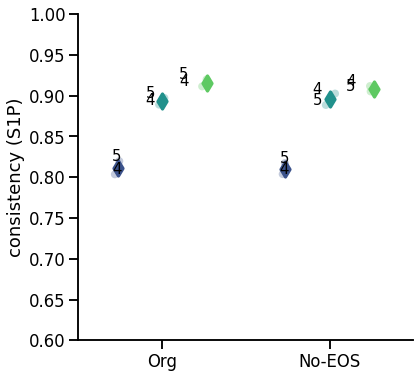

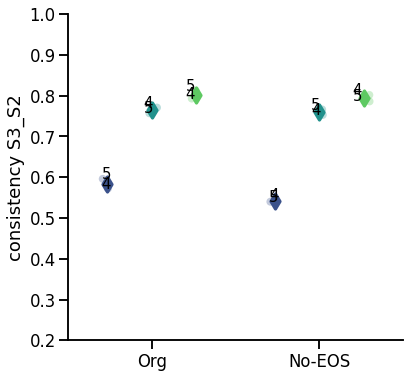

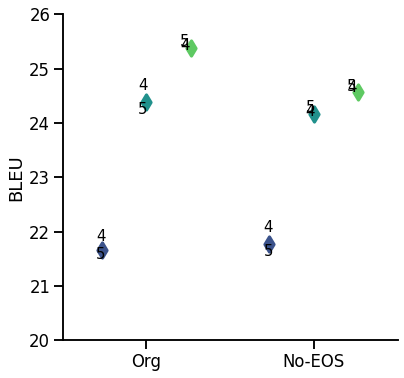

In [57]:
plt.figure(figsize=(6, 6))
sns.stripplot(x=hue, y=s1p_results, hue=models, dodge=True, zorder=1, label=None, alpha=0.3, size=8, palette="viridis")
ax = sns.pointplot(x=hue, y=s1p_results, hue=models,
              dodge=.532, join=False, 
              markers="d", scale=1.05, ci=None, palette="viridis")
plt.legend([], [], frameon=False)
sns.despine(top=True, right=True)
#ax.set_xticklabels(["synthetic", "semi-n.", "natural"])
ax.set_xticklabels(["Org", "No-EOS"])
ax.set_ylabel("consistency (S1P)")
plt.ylim(0.6, 1)
for y, x, m, t in s1p_all_annotations:
    if x == "natural":
        continue
    #x = {"synthetic": 0, "semi_natural": 1, "natural": 2}[x]
    x = {"not_permuted": 0, "remove_eos_not_permuted": 1}[x]
    if m == "tiny":
        x -= 0.3
    if m == "small":
        x -=0.1
    if m == "all":
        x += 0.1
    plt.text(x, y, t, fontsize=15)
#plt.savefig("/checkpoint/itayitzhak/figures/s1p.pdf", bbox_inches="tight")
plt.show()


plt.figure(figsize=(6, 6))
ax = sns.pointplot(x=hue, y=s3_results, hue=models,
              dodge=.532, join=False, 
              markers="d", scale=1.05, ci=None, palette="viridis")
sns.stripplot(x=hue, y=s3_results, hue=models, dodge=True, zorder=-1, label=None, alpha=0.3, size=8, palette="viridis")
plt.legend([], [], frameon=False) #["tiny", "small", "all"], bbox_to_anchor=(0.57, 1.05))
sns.despine(top=True, right=True)
#ax.set_xticklabels(["synthetic", "semi-n.", "natural"])
ax.set_xticklabels(["Org", "No-EOS"])
ax.set_ylabel("consistency S3_S2")
plt.ylim(0.2, 1)
for y, x, m, t in s3_all_annotations:
    if x == "natural":
        continue
    #x = {"synthetic": 0, "semi_natural": 1, "natural": 2}[x]
    x = {"not_permuted": 0, "remove_eos_not_permuted": 1}[x]
    if m == "tiny":
        x -= 0.3
    if m == "small":
        x -=0.05
    if m == "all":
        x += 0.2
    plt.text(x, y, t, fontsize=15)
#ax.set_yticks([])
#plt.savefig("/checkpoint/itayitzhak/figures/s3.pdf", bbox_inches="tight")
plt.show()

plt.figure(figsize=(6, 6))
ax = sns.pointplot(x=hue, y=bleu_results, hue=models,
              dodge=.532, join=False, 
              markers="d", scale=1.05, ci=None, palette="viridis")
sns.stripplot(x=hue, y=s3_results, hue=models, dodge=True, zorder=-1, label=None, alpha=0.3, size=8, palette="viridis")
plt.legend([], [], frameon=False) #["tiny", "small", "all"], bbox_to_anchor=(0.57, 1.05))
sns.despine(top=True, right=True)
#ax.set_xticklabels(["synthetic", "semi-n.", "natural"])
ax.set_xticklabels(["Org", "No-EOS"])
ax.set_ylabel("BLEU")
plt.ylim(20, 26)
for y, x, m, t in bleu_all_annotations:
    if x == "natural":
        continue
    #x = {"synthetic": 0, "semi_natural": 1, "natural": 2}[x]
    x = {"not_permuted": 0, "remove_eos_not_permuted": 1}[x]
    if m == "tiny":
        x -= 0.3
    if m == "small":
        x -=0.05
    if m == "all":
        x += 0.2
    plt.text(x, y, t, fontsize=15)
#ax.set_yticks([])
#plt.savefig("/checkpoint/itayitzhak/figures/s3.pdf", bbox_inches="tight")
plt.show()

### Create DF for plots

In [20]:
def change_for_plot(value):
    if value == 'trained_data_type': return 'Training Data Type'
    if value == 'not_permuted_without_eos': return 'Trained With Original Data'
    if value == 'not_permuted': return 'Trained With Original Data (Analysis With EOS)'
    if value == 'remove_eos_not_permuted': return 'Trained Without EOS'
    if value == 'model_distance_weighted_median': return 'Distance Weighted Median'
    if value == 'model_globality_scores': return 'Globality'
    if value == 'trained_data_size': return 'Data Size'
    if value == 'model_bleu': return 'BLEU'
    if value == 'distance_weighted_median': return 'Distance Weighted Median Distrubation'     
    if value == 's_conj_s1p_s2_consist': return 's_conj s1p_s2 Consistency'  
    if value == 's_conj_s3_s2_consist': return 's_conj s3_s2 Consistency'
    if value == 's_np_vp_np_prime_consist': return 's_np_vp np_prime Consistency'
    if value == 's_np_vp_vp_prime_consist': return 's_np_vp vp_prime Consistency'
    if type(value)==type([]) and type(value[0])==type([]): return flatten(value)# nested list
 
    return value

def create_df_from_results(models_final_results, wanted_keys, wanted_y, wanted_conds, templates_to_use, explode_wanted_y=True):
    data_to_plot = dict()
    for wanted_key in wanted_keys:
        data_to_plot[change_for_plot(wanted_key)] = []
    data_to_plot['model_name'] = []
        
    for cur_model_path, results in models_final_results.items():
        if results['conds'] == wanted_conds and results['template'] in templates_to_use:
            print(f"cur_model_path:{cur_model_path}")
            #data_to_plot['model_name'].append(cur_model_path)
            max_values_number = 0
            for key, value in results.items():
                if key in wanted_keys:
                    print(key)
                    data_to_plot[change_for_plot(key)].append(change_for_plot(value))
                    if type(value) == type([]): # added after get_bar_plot
                        max_values_number = max(max_values_number,len(value))
                    else:
                        max_values_number = max(max_values_number,1)
            # for key, value in data_to_plot.items():
            #     cur_value_len = len(value)
            #     for i in range(max_values_number - cur_value_len) :
            #         data_to_plot[change_for_plot(key)].append(change_for_plot(value))
                # if key in wanted_keys:
                #     if type(value) == type([]): # added after get_bar_plot
                #         for mini_value in value:
                #             data_to_plot['model_name'].append(cur_model_path)
                #             data_to_plot[change_for_plot(key)].append(change_for_plot(value))
                #     else:
                #         data_to_plot['model_name'].append(cur_model_path)
                #         data_to_plot[change_for_plot(key)].append(change_for_plot(value))
            
    
    # for key,value in data_to_plot.items():
    #     print(f"key={key}")
    #     print(f"value={value}")
    #     print(f"len(value)={len(value)}")
    #     print(f"type(value)={type(value)}")
    #     print("*"*20)
    #models_names = [x.split('\\')[-1] for x in list(models_final_results.keys())]
    models_names = list(data_to_plot['model_name'])
    print(f"models_names:{models_names}")
    print(f"data_to_plot:{data_to_plot}")
    data_to_plot = pd.DataFrame(data_to_plot, index = models_names)
    if explode_wanted_y:
        data_to_plot = data_to_plot.explode(wanted_y)
    
#     print(f"data_to_plot[wanted_y].head():{data_to_plot[wanted_y].head()}")
#     print(f"len(data_to_plot):{len(data_to_plot)}")

    return data_to_plot

KeyboardInterrupt: 

In [ ]:
plot_globalality_to_consistenecy(temp_all_models_final_results, ["all_sampels_s_conj_s1p_s2_consist", "all_sampels_gloablity", "all_sampels_weighted_median_distance"], wanted_conds=('s_conj','s1_s2'),templates_to_use=[1])

### Bar Plots

In [97]:
def get_bar_plot(models_final_results, wanted_keys, wanted_y, ylim, wanted_conds=('s_conj','s1_s2'),templates_to_use=[i for i in range(1,11)]):
    data_to_plot = create_df_from_results(models_final_results, wanted_keys, wanted_y, wanted_conds, templates_to_use)
    sns.set_context('paper')
    sns.set(rc={'figure.figsize':(8,4)})
    plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
    plt.tight_layout()
    sns.set(font_scale=0.8)
    plt.ylim(ylim[0], ylim[1])
    
#     ax = sns.barplot(x = 'Data Size', y = wanted_y, data = data_to_plot,
#             palette = 'hls', hue = 'Training Data Type',
#             #order = ['trained_data_size'],#['tiny', 'small', 'all'],  
#             capsize = 0.05,             
#             saturation = 12,             
#             errcolor = 'gray', errwidth = 2,  
#             ci = 'sd'   
#             )
    ax = sns.scatterplot(x = 'Data Size', y = wanted_y, hue = 'Training Data Type', data = data_to_plot, s=80)
    plt.show()

In [98]:
get_bar_plot(all_models_final_results,
             ['trained_data_type','trained_data_size','model_distance_weighted_median','model_globality_scores'],
             wanted_y='Distance Weighted Median', ylim=(2,8),
             wanted_conds = ('s_conj','s1_s2')
            )

get_bar_plot(all_models_final_results,
             ['trained_data_type','trained_data_size','model_distance_weighted_median','model_globality_scores'],
             wanted_y='Globality', ylim=(0.21,0.3),
             wanted_conds = ('s_conj','s1_s2')
            )

get_bar_plot(all_models_final_results,
             ['trained_data_type','trained_data_size','model_bleu'],
             wanted_y='BLEU', ylim=(20,26),
             wanted_conds = ('s_conj','s1_s2')
            )


NameError: name 'all_models_final_results' is not defined

No handles with labels found to put in legend.


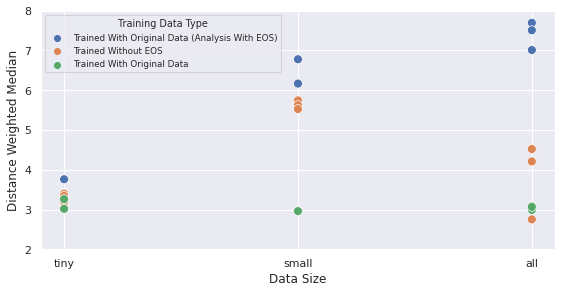

No handles with labels found to put in legend.


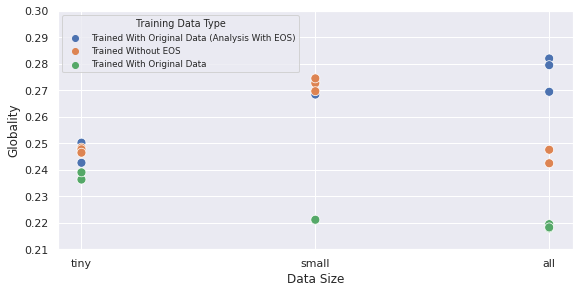

No handles with labels found to put in legend.


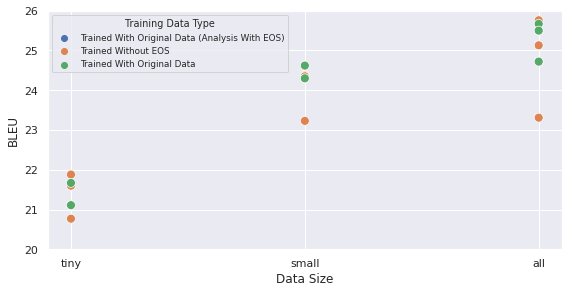

In [125]:
get_bar_plot(all_models_final_results,
             ['trained_data_type','trained_data_size','model_distance_weighted_median','model_globality_scores'],
             wanted_y='Distance Weighted Median', ylim=(2,8),
             wanted_conds = ('s_conj','s1_s2'),
             templates_to_use=[2]
            )

get_bar_plot(all_models_final_results,
             ['trained_data_type','trained_data_size','model_distance_weighted_median','model_globality_scores'],
             wanted_y='Globality', ylim=(0.21,0.3),
             wanted_conds = ('s_conj','s1_s2'),
             templates_to_use=[2]
            )

get_bar_plot(all_models_final_results,
             ['trained_data_type','trained_data_size','model_bleu'],
             wanted_y='BLEU', ylim=(20,26),
             wanted_conds = ('s_conj','s1_s2'),
             templates_to_use=[2]
            )

No handles with labels found to put in legend.


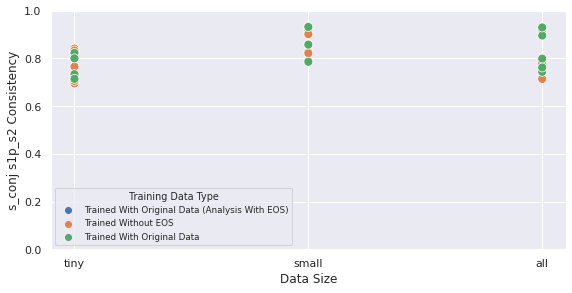

No handles with labels found to put in legend.


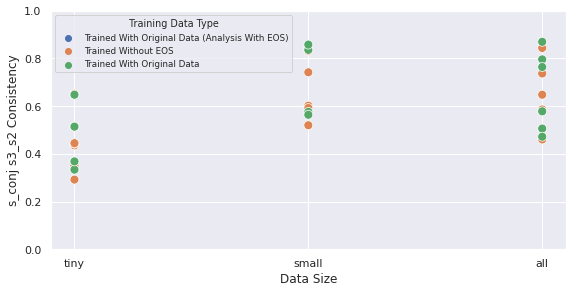

No handles with labels found to put in legend.


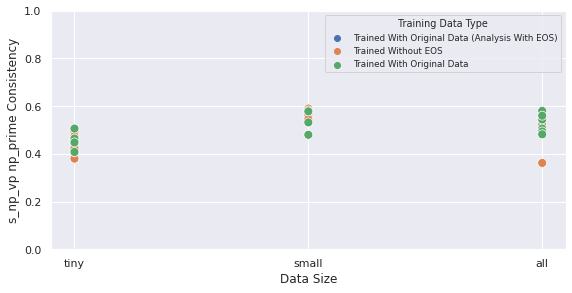

No handles with labels found to put in legend.


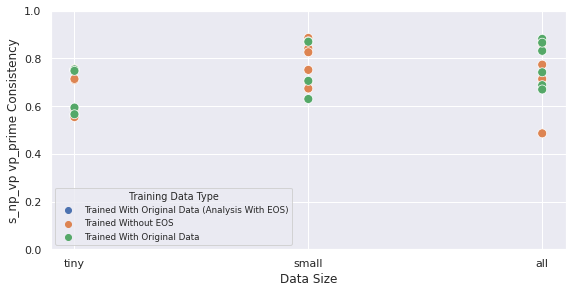

In [126]:
get_bar_plot(all_models_final_results,
             ['trained_data_type','trained_data_size','s_conj_s1p_s2_consist'],
             wanted_y='s_conj s1p_s2 Consistency', ylim=(0,1),
             wanted_conds = ('s_conj','s1_s2')
            )

get_bar_plot(all_models_final_results,
             ['trained_data_type','trained_data_size','s_conj_s3_s2_consist'],
             wanted_y='s_conj s3_s2 Consistency', ylim=(0,1),
             wanted_conds = ('s_conj','s1_s2')
            )


get_bar_plot(all_models_final_results,
             ['trained_data_type','trained_data_size','s_np_vp_np_prime_consist'],
             wanted_y='s_np_vp np_prime Consistency', ylim=(0,1),
             wanted_conds = ('s_np_vp','np')
            )

get_bar_plot(all_models_final_results,
             ['trained_data_type','trained_data_size','s_np_vp_vp_prime_consist'],
             wanted_y='s_np_vp vp_prime Consistency', ylim=(0,1),
             wanted_conds = ('s_np_vp','np')
            )

No handles with labels found to put in legend.


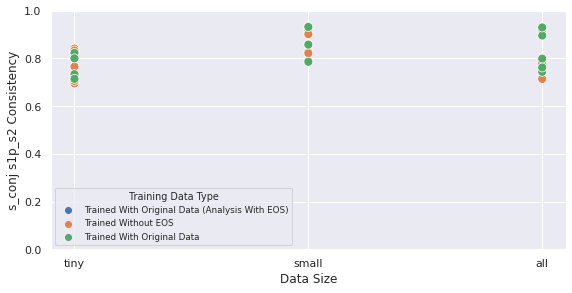

No handles with labels found to put in legend.


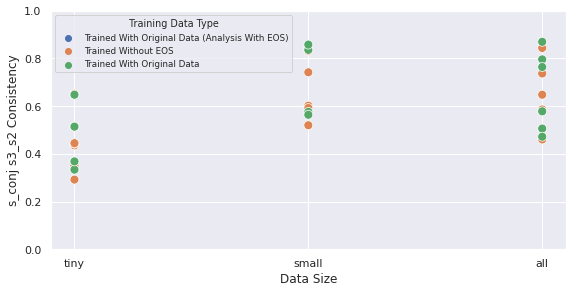

No handles with labels found to put in legend.


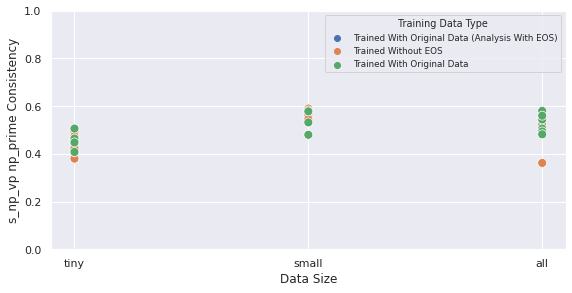

No handles with labels found to put in legend.


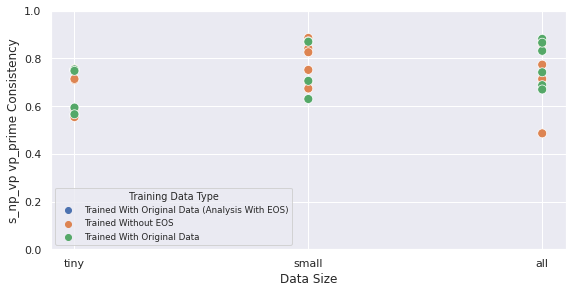

In [127]:
get_bar_plot(all_models_final_results,
             ['trained_data_type','trained_data_size','s_conj_s1p_s2_consist'],
             wanted_y='s_conj s1p_s2 Consistency', ylim=(0,1),
             wanted_conds = ('s_conj','s1_s2')
            )

get_bar_plot(all_models_final_results,
             ['trained_data_type','trained_data_size','s_conj_s3_s2_consist'],
             wanted_y='s_conj s3_s2 Consistency', ylim=(0,1),
             wanted_conds = ('s_conj','s1_s2')
            )


get_bar_plot(all_models_final_results,
             ['trained_data_type','trained_data_size','s_np_vp_np_prime_consist'],
             wanted_y='s_np_vp np_prime Consistency', ylim=(0,1),
             wanted_conds = ('s_np_vp','np')
            )

get_bar_plot(all_models_final_results,
             ['trained_data_type','trained_data_size','s_np_vp_vp_prime_consist'],
             wanted_y='s_np_vp vp_prime Consistency', ylim=(0,1),
             wanted_conds = ('s_np_vp','np')
            )

### Verna's Plots

key=Training Data Type
********************
key=Data Size
********************
key=Distance Weighted Median Distrubation
********************


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (9).

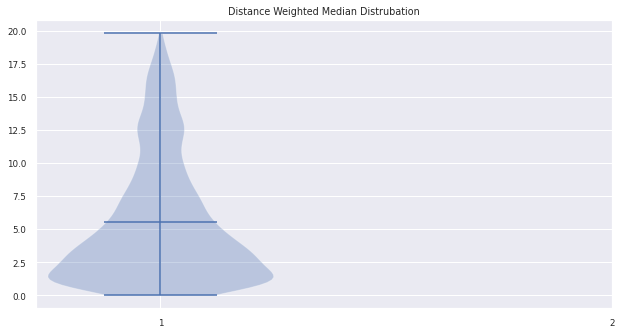

In [190]:
def show_violin_new(models_final_results, wanted_keys, wanted_y, wanted_conds=('s_conj','s1_s2')):
    data_to_plot = create_df_from_results(models_final_results, wanted_keys, wanted_y, wanted_conds)
    labels = (data_to_plot['Training Data Type'] + data_to_plot['Data Size']).unique()
    dists = list(data_to_plot[wanted_y])
    fig = plt.figure()
    ax1 = fig.add_axes([0,0,1,1])
    #print(f"dists:{dists}")
    bp_eos = ax1.violinplot(dists, showmeans=True)
    ax1.set_title(wanted_y)
    ax1.set_xticks([1,2])
    ax1.set_xticklabels(labels, rotation=0)

    plt.show()

show_violin_new(
    all_models_final_results,
    ['trained_data_type','trained_data_size','distance_weighted_median'],
    'Distance Weighted Median Distrubation', wanted_conds=('s_conj','s1_s2'))

In [ ]:
def show_violin(dists, title, labels):
    # df_all_eos_foucesed_heads = pd.DataFrame(all_eos_foucesed_heads).transpose()
    # ax = sns.violinplot(x=["a", "b"],data=df_all_eos_foucesed_heads)

    # Create a figure instance
    fig = plt.figure()

    #fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,6), sharex=False)

    # Create an axes instance
    ax1 = fig.add_axes([0,0,1,1])
    # ax2 = fig.add_axes([0,0,1,1])
    # ax3 = fig.add_axes([0,0,1,1])

    # Create the boxplot
    #ax1.xlabels(["a","b","c","a","b","c"])
    bp_eos = ax1.violinplot(dists, showmeans=True)

    # plt.show()
    # bp = ax.violinplot(all_distance_weighted_median)
    # plt.show()
    # bp = ax.violinplot(all_globality_scores)
    ax1.set_title(title)

    #ax1.set_xticklabels(["0","Not Permuted (Small)","5-gram Permuted (Small)","Permuted (Small)","Not Permuted (All)","5-gram Permuted (All)","Permuted (All)"], rotation=90)
    ax1.set_xticks([1,2])
    ax1.set_xticklabels(labels, rotation=0)

    plt.show()

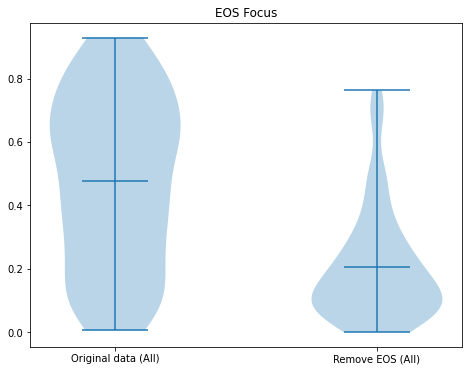

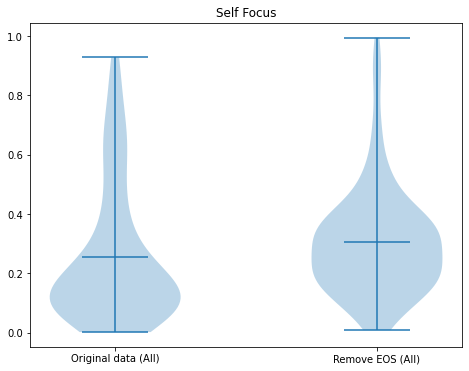

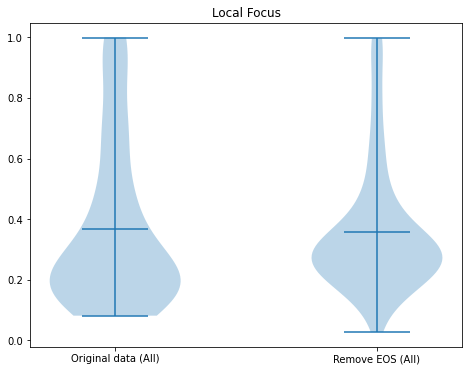

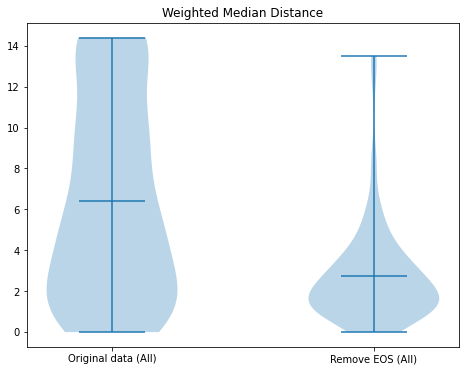

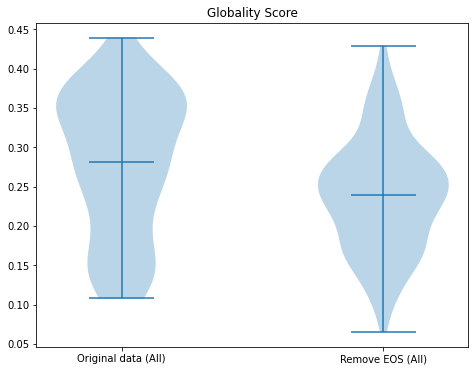

In [480]:
show_violin(all_eos_foucesed_heads, 'EOS Focus', ["Original data (All)","Remove EOS (All)"])
show_violin(all_self_heads, 'Self Focus', ["Original data (All)","Remove EOS (All)"])
show_violin(all_local_heads, 'Local Focus', ["Original data (All)","Remove EOS (All)"])
show_violin(all_distance_weighted_median, 'Weighted Median Distance', ["Original data (All)","Remove EOS (All)"])
show_violin(all_globality_scores, 'Globality Score', ["Original data (All)","Remove EOS (All)"])

In [485]:
def print_single_ttest(H_0,H_1,name_1,name_2):
    print(f"T-test for {name_1} vs {name_2}",end=':')
    print(f"p-value <= {stats.ttest_ind(H_0, H_1)[1]:.4f}")
    
def calc_ttest(data_for_ttest):
#     print("T-test for Not Permuted vs 5-gram Permuted (Small)",end=':')
#     print(f"p-value <= {stats.ttest_ind(data_for_ttest[0], data_for_ttest[1])[1]:.2f}")
    print_single_ttest(data_for_ttest[0],data_for_ttest[1],"Not Permuted","5-gram Permuted (Small)")
    print("T-test for Not Permuted vs Permuted (Small)",end=':')
    print(f"p-value <= {stats.ttest_ind(data_for_ttest[0], data_for_ttest[2])[1]:.2f}")
    print("T-test for Not Permuted vs 5-gram Permuted (All)",end=':')
    print(f"p-value <= {stats.ttest_ind(data_for_ttest[3], data_for_ttest[4])[1]:.2f}")
    print("T-test for Not Permuted vs Permuted (All)",end=':')
    #print(stats.ttest_ind(all_distance_weighted_median[3], all_distance_weighted_median[5]))
    print(f"p-value <= {stats.ttest_ind(data_for_ttest[3], data_for_ttest[5])[1]:.2f}")
# calc_ttest(all_distance_weighted_median)


In [486]:
print_single_ttest(all_eos_foucesed_heads[0],all_eos_foucesed_heads[1],"EOS Original data (All)","EOS Remove EOS (All)")
print_single_ttest(all_self_heads[0],all_self_heads[1],"SELF Original data (All)"," SELF Remove EOS (All)")
print_single_ttest(all_local_heads[0],all_local_heads[1],"LOCAL Original data (All)","Local Remove EOS (All)")
print_single_ttest(all_distance_weighted_median[0],all_distance_weighted_median[1],"Weighted Distance Original data (All)","Weighted Distance Remove EOS (All)")
print_single_ttest(all_globality_scores[0],all_globality_scores[1],"Globality Original data (All)","Gloablity Remove EOS (All)")

T-test for EOS Original data (All) vs EOS Remove EOS (All):p-value <= 0.0000
T-test for SELF Original data (All) vs  SELF Remove EOS (All):p-value <= 0.0398
T-test for LOCAL Original data (All) vs Local Remove EOS (All):p-value <= 0.6598
T-test for Weighted Distance Original data (All) vs Weighted Distance Remove EOS (All):p-value <= 0.0000
T-test for Globality Original data (All) vs Gloablity Remove EOS (All):p-value <= 0.0000


<ipython-input-382-d8c9eed61aa8>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(["0","Not Permuted (Small)","5-gram Permuted (Small)","Permuted (Small)","Not Permuted (All)","5-gram Permuted (All)","Permuted (All)"], rotation=90)


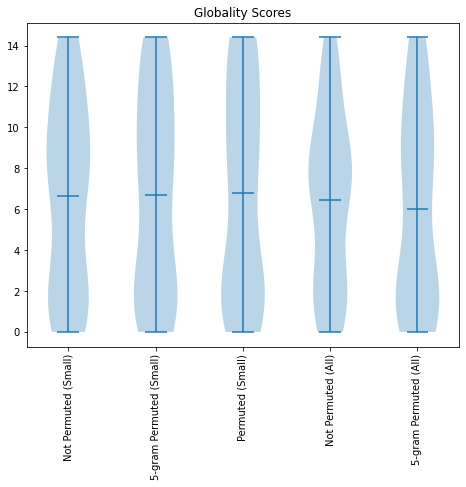

In [382]:
# df_all_eos_foucesed_heads = pd.DataFrame(all_eos_foucesed_heads).transpose()
# ax = sns.violinplot(x=["a", "b"],data=df_all_eos_foucesed_heads)

# Create a figure instance
fig = plt.figure()

# Create an axes instance
ax1 = fig.add_axes([0,0,1,1])

# Create the boxplot
bp_eos = ax1.violinplot(all_seeds_distance_weighted_median, showmeans=True)

ax1.set_title('Globality Scores')
ax1.set_xticklabels(["0","Not Permuted (Small)","5-gram Permuted (Small)","Permuted (Small)","Not Permuted (All)","5-gram Permuted (All)","Permuted (All)"], rotation=90)

plt.show()

### Consistency Vs. Globality

In [18]:
sns.set_context("talk")
#results = pickle.load(open("/checkpoint/itayitzhak/all_models_final_results_templates.pt", 'rb'))
results = temp_all_models_final_results
all_seeds = range(4,5)
all_templates = list(range(1,2))
all_trained_data_type = ['remove_eos_not_permuted']#["not_permuted"]#["not_permuted", 'remove_eos_not_permuted']
all_text_types = ["synthetic"]
all_data_sizes = ["all"]#["tiny", "small", "all"]

with_samples_globalities = True

s1p_results = []
s3_results = []
bleu_results = []
models = [] 
hue = []
s1p_all_annotations = []
s3_all_annotations = []
bleu_all_annotations = []

#for text_type in ["synthetic", "semi_natural", "natural"]:
for text_type in all_text_types:
    for trained_data_type in all_trained_data_type:
        for data_size in all_data_sizes:
            s1p_annotations = []
            s3_annotations = []
            bleu_annotations = []
            #for t in range(1, 11):
            for i_seed, seed in enumerate(all_seeds):
    #             size_results = [results[(f"transformer_{model}_{seed}", seed, "s_conj", data_type, t)]
    #                             for seed in [1, 2, 3, 4, 5]]
#                 s1p = results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['s_conj_s1p_s2_consist']
#                 s3 = results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['s_conj_s3_s2_consist']
#                 bleu = results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['model_bleu']
#                 if trained_data_type == "not_permuted" and data_size != 'all' and seed == 3:
#                         continue
                print(f"seed={seed}")
                print([results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['all_sampels_s_conj_s1p_s2_consist'][i_seed]
                      for t in all_templates])
                samples_s1p = [results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['all_sampels_s_conj_s1p_s2_consist'][i_seed]
                      for t in all_templates
                      ]
                samples_s3 = [results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['all_sampels_s_conj_s3_s2_consist'][i_seed]
                      for t in all_templates
                      ]
                samples_globalities = [results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['all_sampels_gloablity'][i_seed]
                  for t in all_templates
                  ]
                samples_weighted_median_distance = [results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['all_sampels_weighted_median_distance'][i_seed]
                  for t in all_templates
                  ]
#                 s3 = results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['s_conj_s3_s2_consist'][seed-1]
#                 bleu = results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['model_bleu'][seed-1]
        
                #s1p, s3 = zip(*size_results)
                # print(f"s1p:{s1p}")
                # print(f"s3:{s3}")
                # print(f"{data_size}_{trained_data_type}_bleu:{bleu}")
#                 s1p_consist_glob_results.append(samples_globalities[samples_s1p])
#                 s3_consist_glob_results.append(samples_globalities[samples_s3])
#                 s1p_not_consist_glob_results.append(samples_globalities[[ not x for x in samples_s1p]])
#                 s3_not_consist_glob_results.append(samples_globalities[[ not x for x in samples_s3]])
                
#                 s1p_consist_wmd_results.append(samples_globalities[samples_s1p])
#                 s3_consist_wmd_results.append(samples_globalities[samples_s3])
#                 s1p_not_consist_wmd_results.append(samples_globalities[[not x for x in samples_s1p]])
#                 s3_not_consist_wmd_results.append(samples_globalities[[not x for x in samples_s3]])
                #print(f"trained_data_type, text_type, t, np.mean(s3)={trained_data_type, text_type, t, np.mean(s3)}")
                #models.append(trained_data_type)
                #hue.append(text_type)
                models.append(data_size)
                hue.append(trained_data_type)
#                 s1p_annotations.append((np.mean(s1p), trained_data_type, data_size, t))
#                 s3_annotations.append((np.mean(s3), trained_data_type, data_size, t))
#                 bleu_annotations.append((np.mean(bleu), trained_data_type, data_size, t))
            #     s1p_annotations.append((np.mean(s1p), trained_data_type, data_size, seed))
            #     s3_annotations.append((np.mean(s3), trained_data_type, data_size, seed))
            #     if with_bleu:    
            #         bleu_annotations.append((np.mean(bleu), trained_data_type, data_size, seed))
            # s3_all_annotations.append(min(s3_annotations))
            # s3_all_annotations.append(max(s3_annotations))
            # s1p_all_annotations.append(min(s1p_annotations))
            # s1p_all_annotations.append(max(s1p_annotations))
            # if with_bleu:
            #     bleu_all_annotations.append(min(bleu_annotations))
            #     bleu_all_annotations.append(max(bleu_annotations))

seed=4
[[True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, 

In [ ]:
def plot_globalality_to_consistenecy(models_final_results, wanted_keys, wanted_conds=('s_conj','s1_s2'),templates_to_use=[1]):
    data_to_plot = create_df_from_results(models_final_results, wanted_keys, False, wanted_conds, templates_to_use, explode_wanted_y=False)
    print(f"data_to_plot={data_to_plot}")
    sns.set_context('paper')
    sns.set(rc={'figure.figsize':(6,4)})
    plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
    plt.tight_layout()
    sns.set(font_scale=0.8)
    plt.ylim(0.26,0.32)
    #ax = sns.scatterplot(x = 'Data Size', y = wanted_y, hue = 'Training Data Type', data = data_to_plot, s=80)
    #fig = plt.figure()
    #ax = fig.add_subplot(111, projection = '3d')
    #ax.scatter(x = data_to_plot["samples_s1p"], y = data_to_plot["samples_globalities"], z = data_to_plot["samples_s3"], s=80)
    #ax = sns.scatterplot(x = wanted_keys[0], y = wanted_keys[1], data = data_to_plot, s=80)
    ax = plt.scatter(x = data_to_plot[wanted_keys[0]], y = data_to_plot[wanted_keys[1]])
    ax.set_xticks(range(0,2))
    ax.set_xticklabels(['Not Consistent','Consistent'])
    plt.show()
    
plot_globalality_to_consistenecy(temp_all_models_final_results, ["all_sampels_s_conj_s1p_s2_consist", "all_sampels_gloablity", "all_sampels_weighted_median_distance"], wanted_conds=('s_conj','s1_s2'),templates_to_use=[1])

In [ ]:
print(f"len(samples_s1p[0]):{len(samples_s1p[0])}")
print(f"len(samples_s3[0]):{len(samples_s3[0])}")
print(f"len(samples_globalities[0]):{len(samples_globalities[1])}")
print(f"len(samples_weighted_median_distance[0]):{len(samples_weighted_median_distance[1])}")

In [38]:
data_to_plot = {
                "samples_s1p": samples_s1p[0],
                "samples_s3": samples_s3[0],
                #"s1p_not_consist_glob_results": s1p_not_consist_glob_results,
                "samples_globalities": samples_globalities[0],
                "samples_weighted_median_distance": samples_weighted_median_distance[0],
                # s3_consist_glob_results.append(samples_globalities[samples_s3])
                # s1p_not_consist_glob_results.append(samples_globalities[[ not x for x in samples_s1p]])
                # s3_not_consist_glob_results.append(samples_globalities[[ not x for x in samples_s3]])
                
                # s1p_consist_wmd_results.append(samples_globalities[samples_s1p])
                # s3_consist_wmd_results.append(samples_globalities[samples_s3])
                # s1p_not_consist_wmd_results.append(samples_globalities[[not x for x in samples_s1p]])
                # s3_not_consist_wmd_results.append(samples_globalities[[not x for x in samples_s3]])
}
data_to_plot = pd.DataFrame(data_to_plot)

In [39]:
data_to_plot

,samples_s1p,samples_s3,samples_globalities,samples_weighted_median_distance
0,True,True,0.205507,4.127083
1,True,True,0.203475,4.485417
2,True,True,0.204095,4.212500
3,True,True,0.202143,4.289583
4,True,False,0.202455,4.250000
...,...,...,...,...
495,True,True,0.187731,5.270833
496,True,True,0.186346,5.145833
497,True,True,0.182647,5.062500
498,True,True,0.183231,5.395833


In [41]:
# Logsitic regression
from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split

np_samples_globalities = np.array(samples_globalities)
np_samples_s1p = np.array(samples_s1p)
print(f"np_samples_globalities.shape={np_samples_globalities.shape}")
print(f"baseline:{(np_samples_s1p.sum())/500}")
w = {0:(500-np_samples_s1p.sum())/500,1:np_samples_s1p.sum()/500}
print(w)
X_train, X_test, y_train, y_test = train_test_split(
    np_samples_globalities[0], np_samples_s1p[0], test_size=0.10, random_state=0)
LRG = linear_model.LogisticRegression(
   random_state = 0,solver = 'liblinear',multi_class = 'auto', class_weight=w)


LRG.fit(X_train.reshape(-1, 1), y_train)
LRG.score(X_test.reshape(-1, 1), y_test)

np_samples_globalities.shape=(1, 500)
baseline:0.938
{0: 0.062, 1: 0.938}


0.94

No handles with labels found to put in legend.


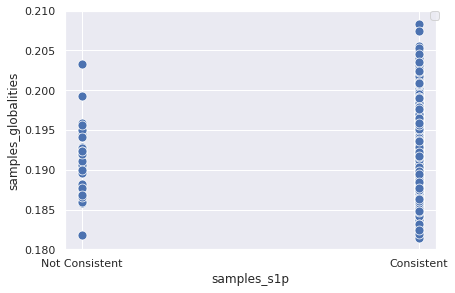

In [46]:
sns.set_context('paper')
sns.set(rc={'figure.figsize':(6,4)})
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
plt.tight_layout()
sns.set(font_scale=0.8)
plt.ylim(0.18,0.21)
#ax = sns.scatterplot(x = 'Data Size', y = wanted_y, hue = 'Training Data Type', data = data_to_plot, s=80)
#fig = plt.figure()
#ax = fig.add_subplot(111, projection = '3d')
#ax.scatter(x = data_to_plot["samples_s1p"], y = data_to_plot["samples_globalities"], z = data_to_plot["samples_s3"], s=80)
ax = sns.scatterplot(x = "samples_s1p", y = "samples_globalities", data = data_to_plot, s=80)
ax.set_xticks(range(0,2))
ax.set_xticklabels(['Not Consistent','Consistent'])
plt.show()

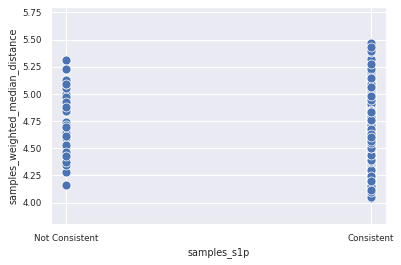

In [47]:
plt.ylim(3.8,5.8)
#ax = sns.scatterplot(x = 'Data Size', y = wanted_y, hue = 'Training Data Type', data = data_to_plot, s=80)
ax = sns.scatterplot(x = "samples_s1p", y = "samples_weighted_median_distance", data = data_to_plot, s=80)
ax.set_xticks(range(0,2))
ax.set_xticklabels(['Not Consistent','Consistent'])
plt.show()

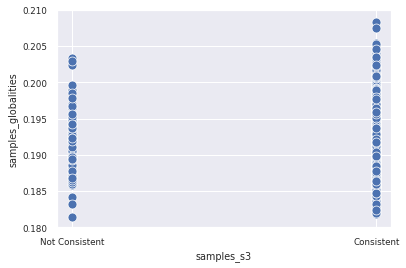

In [48]:
plt.ylim(0.18,0.21)
#ax = sns.scatterplot(x = 'Data Size', y = wanted_y, hue = 'Training Data Type', data = data_to_plot, s=80)
ax = sns.scatterplot(x = "samples_s3", y = "samples_globalities", data = data_to_plot, s=80)
ax.set_xticks(range(0,2))
ax.set_xticklabels(['Not Consistent','Consistent'])
plt.show()

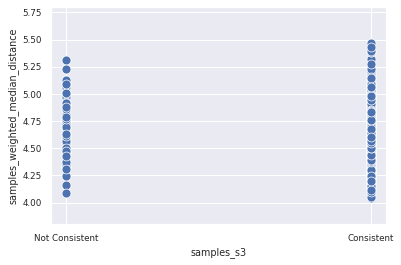

In [49]:
plt.ylim(3.8,5.8)
#ax = sns.scatterplot(x = 'Data Size', y = wanted_y, hue = 'Training Data Type', data = data_to_plot, s=80)
ax = sns.scatterplot(x = "samples_s3", y = "samples_weighted_median_distance", data = data_to_plot, s=80)
ax.set_xticks(range(0,2))
ax.set_xticklabels(['Not Consistent','Consistent'])
plt.show()

In [63]:
show_violin(data_to_plot, "samples_weighted_median_distance", ["samples_s3"])

NameError: name 'show_violin' is not defined

### Histograms

In [54]:
def plot_hist(cur_model_path, model_results, y_type):
    #eos_foucesed_heads, self_heads, local_heads, distance_weighted_median, globality_scores = calc_percentage_of_attn_head_type(avg_attn_matrix)
    if y_type == 'EOS':
        data_to_plot = model_results['eos_foucesed_heads']
        xlim = (0,1.0)
        color = "blue"
    if y_type == 'Local':
        data_to_plot = model_results['local_heads']
        color = 'red'
        xlim = (0,1.0)
    if y_type == 'Self':
        data_to_plot = model_results['self_heads']
        color = 'green'
        xlim = (0,1.0)
    if y_type == 'Distance weighted median':
        data_to_plot = model_results['distance_weighted_median']
        color = 'orange'
        xlim = (0,16)
    if y_type == 'Globality Score':
        data_to_plot = model_results['globality_scores']
        color = 'grey'
        xlim = (0,0.5)
        
        #print(f"len(data_to_plot):{len(data_to_plot)}")
        #print(f"len(list(model_results['lengths_dict'].values())):{len(list(model_results['lengths_dict'].values()))}")
        #print(f"np.array(data_to_plot).shape:{np.array(data_to_plot).shape}")
    data_to_plot = np.average(data_to_plot, weights=list(model_results['lengths_dict'].values()), axis = 0)
        #print(f"data_to_plot.shape:{data_to_plot.shape}")
    plt.hist(data_to_plot, alpha=0.5, label=y_type, histtype='bar', color=f'{color}')

    plt.legend(loc='upper right')
    plt.ylabel('Number of Heads')
    plt.xlabel(f'{y_type} Attention')
    plt.ylim(0,24)
    plt.xlim(xlim[0],xlim[1])
    
    if model_results['trained_data_type'] == 'remove_eos_not_permuted':
        data_type = 'Without EOS'
    if model_results['trained_data_type'] == 'not_permuted':
        data_type = 'Original_(with EOS)'
    if model_results['trained_data_type'] == 'not_permuted_without_eos':
        data_type = 'Original'
    if model_results['trained_data_size'] == 'tiny':
        data_size = 'Small'
    if model_results['trained_data_size'] == 'small':
        data_size = 'Medium'
    if model_results['trained_data_size'] == 'all':
        data_size = 'Large'
        
    plt.title(f"{data_size} {data_type}  {model_results['text_type']} systematicity {model_results['template']}")

    plt.show()
    #plt.savefig(f"EOS_{cond}_{cond_name}_Train_size={size}_Length={LENGTH}.pdf", bbox_inches='tight')

not_permuted_all_synthetic_('s_conj', 's1_s2')_1_compositional_mt__
[0.1001017844304442, 0.10389035940170288, 0.1338771194219589, 0.28151881098747256, 0.16934141814708709, 0.5185122489929199, 0.6020112112164494, 0.02105253003537655, 0.009257812239229678, 0.6910517930984497]


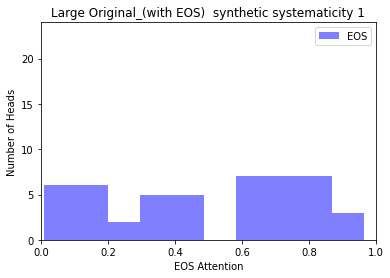

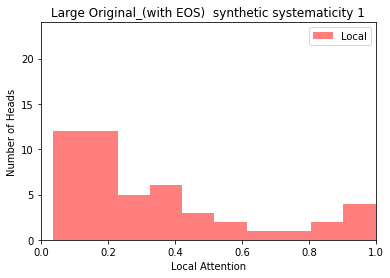

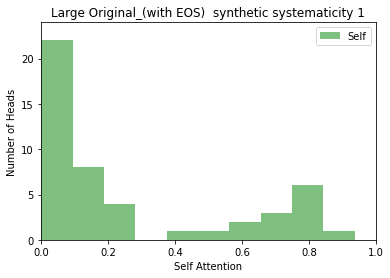

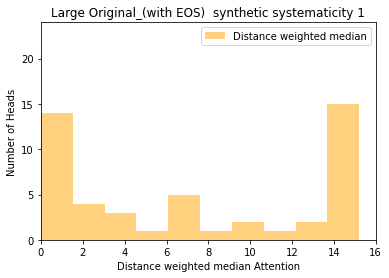

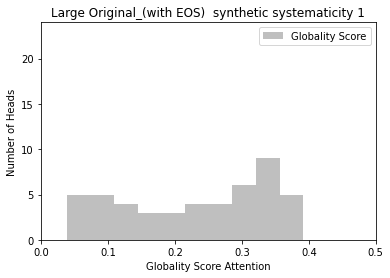

remove_eos_not_permuted_all_synthetic_('s_conj', 's1_s2')_1_compositional_mt__
[0.028719712514430312, 0.3756474629044538, 0.04871110320091249, 0.08660193905234337, 0.1474716141819955, 0.011812865221872932, 0.6167795421555647, 0.019526459462940696, 0.12737697288393984, 0.17046134173870087]


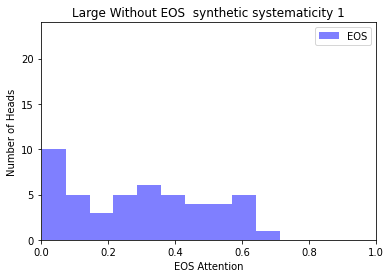

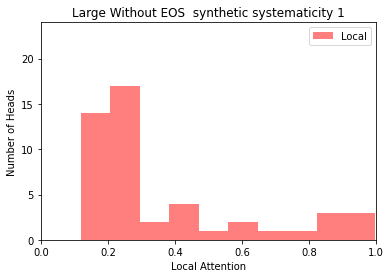

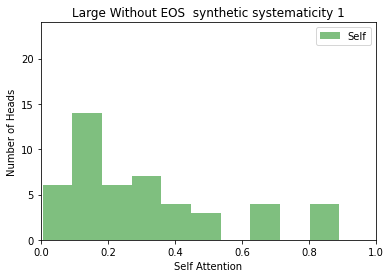

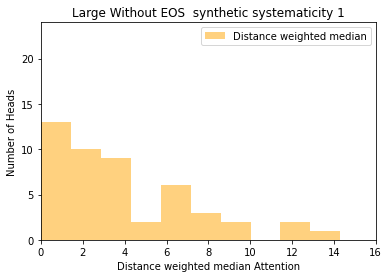

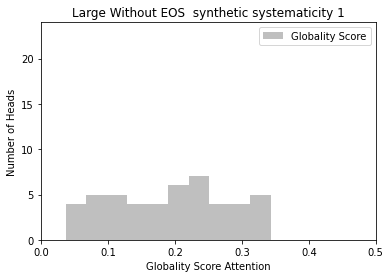

not_permuted_without_eos_all_synthetic_('s_conj', 's1_s2')_1_compositional_mt__
[0.0015039906953461474, 0.29054983556270614, 0.017645234987139703, 0.05424579307436944, 0.013627018034458165, 0.011695784516632566, 0.02286749517079446, 0.005699755763635043, 0.09223330467939378, 0.04596309177577497]


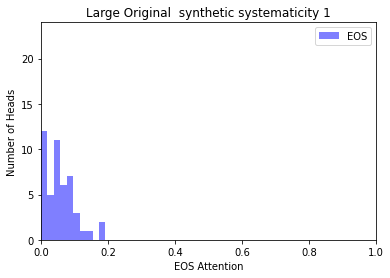

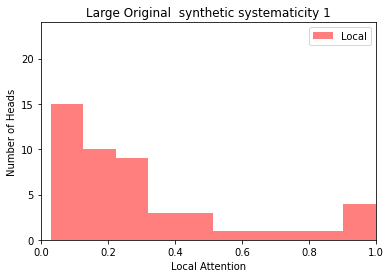

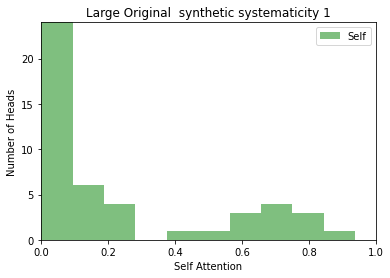

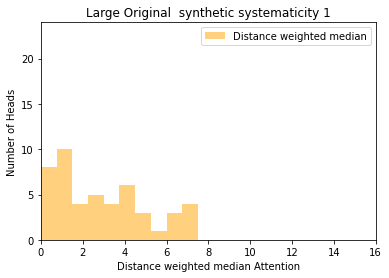

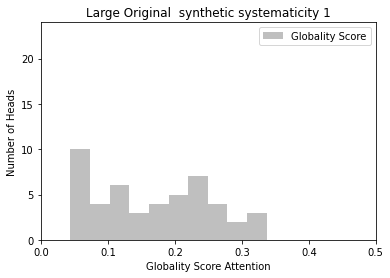

In [56]:
#all_models_final_results
for cur_model_path, results in temp_all_models_final_results.items():
    print(cur_model_path)
    print(results['eos_foucesed_heads'][0][:10])
    plot_hist(cur_model_path, results, "EOS")
    plot_hist(cur_model_path, results, "Local")
    plot_hist(cur_model_path, results, "Self")
    plot_hist(cur_model_path, results, "Distance weighted median")
    plot_hist(cur_model_path, results, "Globality Score")
    print("="*100)

### Layer Plots

In [184]:
def display_focus_across_layers(cur_focus, label, color='blue'):
    layer_mean = []
    layer_percentile = []
    for i in range(0,NUM_LAYERS*NUM_HEADS,NUM_HEADS):
        layer_mean.append(sum(cur_focus[i:i+NUM_HEADS]) / NUM_HEADS)
        layer_percentile.append(np.percentile(cur_focus[i:i+NUM_HEADS], 90))

    if label == 'EOS': color = "blue"
    if label == 'Local': color = 'red'
    if label == 'Self': color = 'green'
    if label == 'Distance weighted median': color = 'orange'
    if label == 'Globality Score': color = 'grey'

    plt.plot(layer_percentile, alpha=1, label=label, color=color, linewidth=3)
    #plt.hist(self_heads, alpha=0.5, label='Self', histtype='bar')
    #plt.hist(local_heads, alpha=0.5, label='Local', histtype='bar')

    plt.legend(loc='lower right')
    #plt.xticks([i for i in range(0,17)])
    plt.ylabel('Attention Weight')
    plt.xlabel('Layer')
    plt.ylim(0,1.0)
    if label == 'Median Distance' or label == 'Distance weighted median': # weighted median distance
        plt.ylim(0,17)
    if label == "Globality Score":
        plt.ylim(0.3,0.5)
        
    #plt.title(f"{cond} {cond_name} | Train_size={size} | Length={LENGTH}")

    #plt.axvline(x=1/LENGTH, color='red', linewidth=0.5)
    #plt.plot([1/LENGTH]*len(local_heads), label='Uniform Weight')


    plt.show()

    print(f"Model:{cur_model_path}")
display_focus_across_layers(eos_foucesed_heads, label='EOS-focus')

NameError: name 'eos_foucesed_heads' is not defined

not_permuted_all_synthetic_('s_conj', 's1_s2')_2_compositional_mt__


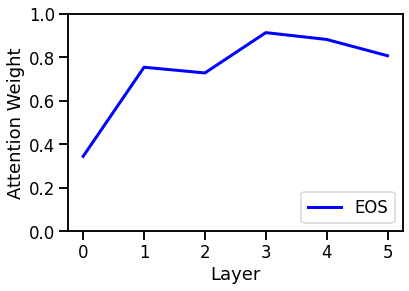

Model:not_permuted_all_synthetic_('s_conj', 's1_s2')_2_compositional_mt__


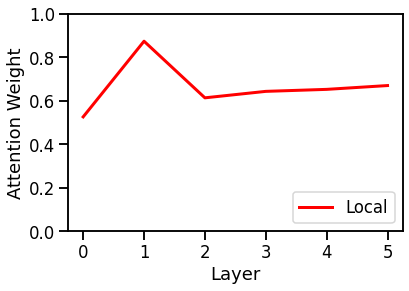

Model:not_permuted_all_synthetic_('s_conj', 's1_s2')_2_compositional_mt__


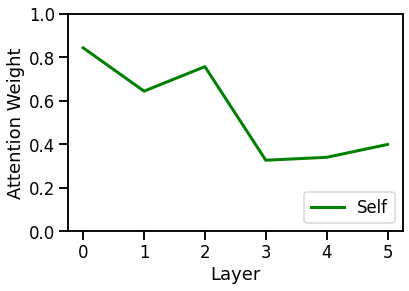

Model:not_permuted_all_synthetic_('s_conj', 's1_s2')_2_compositional_mt__


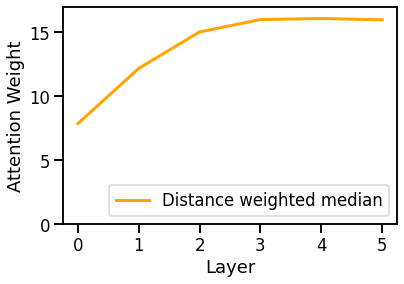

Model:not_permuted_all_synthetic_('s_conj', 's1_s2')_2_compositional_mt__


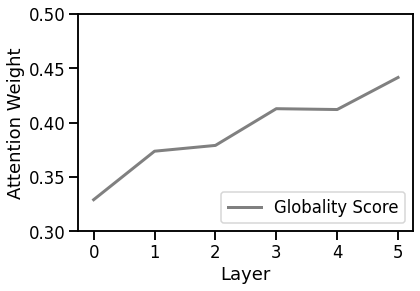

Model:not_permuted_all_synthetic_('s_conj', 's1_s2')_2_compositional_mt__
remove_eos_not_permuted_all_synthetic_('s_conj', 's1_s2')_2_compositional_mt__


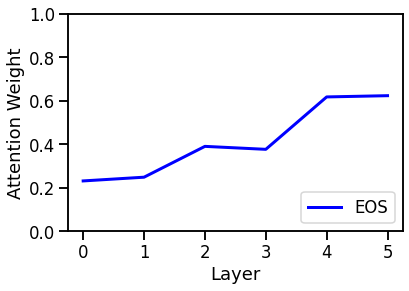

Model:remove_eos_not_permuted_all_synthetic_('s_conj', 's1_s2')_2_compositional_mt__


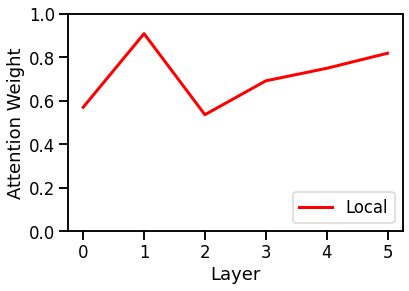

Model:remove_eos_not_permuted_all_synthetic_('s_conj', 's1_s2')_2_compositional_mt__


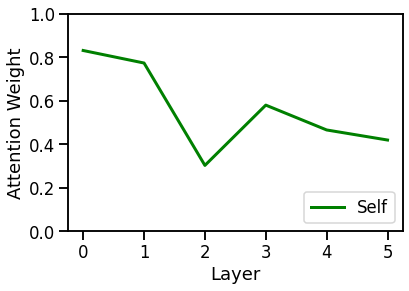

Model:remove_eos_not_permuted_all_synthetic_('s_conj', 's1_s2')_2_compositional_mt__


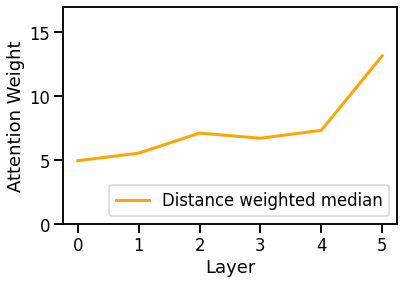

Model:remove_eos_not_permuted_all_synthetic_('s_conj', 's1_s2')_2_compositional_mt__


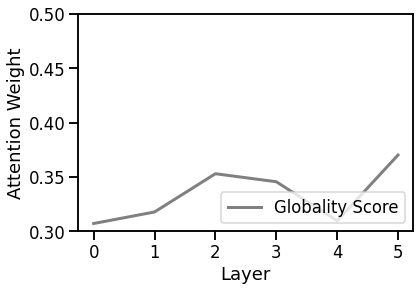

Model:remove_eos_not_permuted_all_synthetic_('s_conj', 's1_s2')_2_compositional_mt__


In [185]:
def data_across_lengths(model_results, wanted_focus):
    return np.average(model_results[wanted_focus], weights=list(model_results['lengths_dict'].values()), axis = 0)

for cur_model_path, results in all_models_final_results.items():
    print(cur_model_path)
    display_focus_across_layers(data_across_lengths(results, 'eos_foucesed_heads'), 'EOS', color='blue')
    display_focus_across_layers(data_across_lengths(results, 'local_heads'), 'Local', color='blue')
    display_focus_across_layers(data_across_lengths(results, 'self_heads'), 'Self', color='blue')
    display_focus_across_layers(data_across_lengths(results, 'distance_weighted_median'), 'Distance weighted median', color='blue')
    display_focus_across_layers(data_across_lengths(results, 'globality_scores'), 'Globality Score', color='blue')
    print("="*100)


### Legacy

Attention Weight threshold is: 0.35.
Majority threshold is: 0.9.
For data "s_conj" "s1_s2" Training_data_size="all" with sentences in Length="20" the measures are:
Percentage of EOS focused heads:  0.00%
Percentage of self focused heads: 5.56%
Percentage of Local focused heads: 5.56%


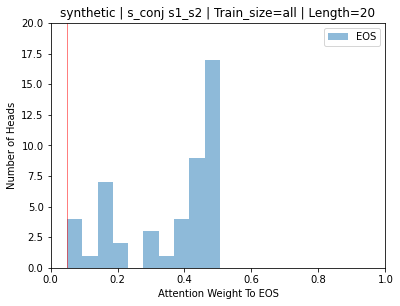

Model:/checkpoint/itayitzhak/attn_weigths/bos_and_eos_at_the_end_seed_1_compositional_mt_systematicity_s_conj_synthetic_systematicity_synthetic_1_s1_s2_all


In [507]:
weight_threshold = 0.35 # 2*1/LENGTH
majority_threshold = 0.9
eos_foucesed_heads, self_heads, local_heads, distance_weighted_median, globality_scores = calc_percentage_of_attn_head_type(avg_attn_matrix, weight_threshold, majority_threshold)

#print(eos_foucesed_heads)
#plt.hist(eos_foucesed_heads, np.unique(eos_foucesed_heads), alpha=0.5, label='EOS')
#plt.hist(local_heads, np.unique(local_heads), alpha=0.5, label='Self')
plt.hist(eos_foucesed_heads, alpha=0.5, label='EOS', histtype='bar')
#plt.hist(self_heads, alpha=0.5, label='Self', histtype='bar')
#plt.hist(local_heads, alpha=0.5, label='Local', histtype='bar')

plt.legend(loc='upper right')
#plt.xticks([i for i in range(0,17)])
plt.ylabel('Number of Heads')
plt.xlabel('Attention Weight To EOS')
plt.ylim(0,20)
plt.xlim(0,1.0)
plt.title(f"{data_type} | {cond} {cond_name} | Train_size={size} | Length={LENGTH}")

plt.axvline(x=1/LENGTH, color='red', linewidth=0.5)
#plt.plot([1/LENGTH]*len(local_heads), label='Uniform Weight')


plt.show()
print(f"Model:{cur_model_path}")
#plt.savefig(f"EOS_{cond}_{cond_name}_Train_size={size}_Length={LENGTH}.pdf", bbox_inches='tight')

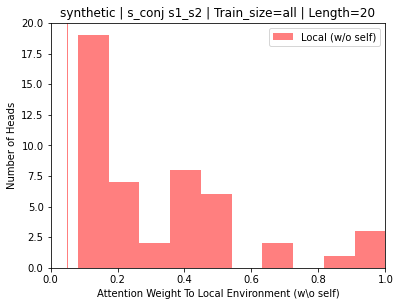

Model:/checkpoint/itayitzhak/attn_weigths/bos_and_eos_at_the_end_seed_1_compositional_mt_systematicity_s_conj_synthetic_systematicity_synthetic_1_s1_s2_all


In [508]:
plt.hist(local_heads, alpha=0.5, label='Local (w/o self)', histtype='bar', color='red')
plt.legend(loc='upper right')

plt.ylabel('Number of Heads')
plt.xlabel('Attention Weight To Local Environment (w\o self)')
plt.ylim(0,20)
plt.xlim(0,1.0)
plt.title(f"{data_type} | {cond} {cond_name} | Train_size={size} | Length={LENGTH}")

plt.axvline(x=1/LENGTH, color='red', linewidth=0.5)


plt.show()
print(f"Model:{cur_model_path}")
#plt.savefig(f"Local_{cond}_{cond_name}_Train_size={size}_Length={LENGTH}.pdf", bbox_inches='tight')

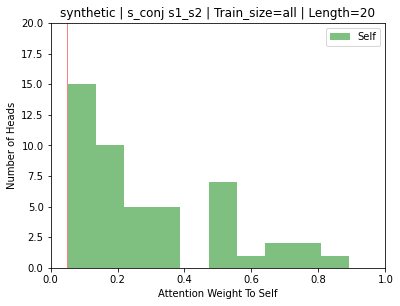

Model:/checkpoint/itayitzhak/attn_weigths/bos_and_eos_at_the_end_seed_1_compositional_mt_systematicity_s_conj_synthetic_systematicity_synthetic_1_s1_s2_all


In [509]:
plt.hist(self_heads, alpha=0.5, label='Self', histtype='bar', color='green')
plt.legend(loc='upper right')

plt.ylabel('Number of Heads')
plt.xlabel('Attention Weight To Self')
plt.ylim(0,20)
plt.xlim(0,1.0)
plt.title(f"{data_type} | {cond} {cond_name} | Train_size={size} | Length={LENGTH}")

plt.axvline(x=1/LENGTH, color='red', linewidth=0.5)


plt.show()
print(f"Model:{cur_model_path}")
#plt.savefig(f"Self_{cond}_{cond_name}_Train_size={size}_Length={LENGTH}.pdf", bbox_inches='tight')

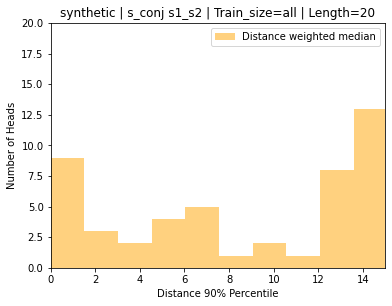

Model:/checkpoint/itayitzhak/attn_weigths/bos_and_eos_at_the_end_seed_1_compositional_mt_systematicity_s_conj_synthetic_systematicity_synthetic_1_s1_s2_all


In [510]:
plt.hist(distance_weighted_median, alpha=0.5, label='Distance weighted median', histtype='bar', color='orange')
plt.legend(loc='upper right')
plt.ylabel('Number of Heads')
plt.xlabel('Majority Distance')
plt.ylim(0,20)
plt.xlim(0,15)
plt.title(f"{data_type} | {cond} {cond_name} | Train_size={size} | Length={LENGTH}")
plt.show()
print(f"Model:{cur_model_path}")
#plt.savefig(f"Distance_weighted_median_{cond}_{cond_name}_Train_size={size}_Length={LENGTH}.pdf", bbox_inches='tight')

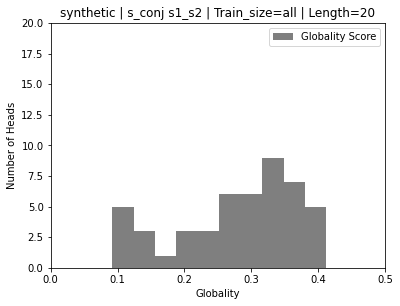

Model:/checkpoint/itayitzhak/attn_weigths/bos_and_eos_at_the_end_seed_1_compositional_mt_systematicity_s_conj_synthetic_systematicity_synthetic_1_s1_s2_all


In [511]:
plt.hist(globality_scores, alpha=0.5, label='Globality Score', histtype='bar', color='black')
plt.legend(loc='upper right')
plt.ylabel('Number of Heads')
plt.xlabel('Globality')
plt.ylim(0,20)
plt.xlim(0,0.5)
plt.title(f"{data_type} | {cond} {cond_name} | Train_size={size} | Length={LENGTH}")
plt.show()
print(f"Model:{cur_model_path}")
#plt.savefig(f"Distance_weighted_median_{cond}_{cond_name}_Train_size={size}_Length={LENGTH}.pdf", bbox_inches='tight')

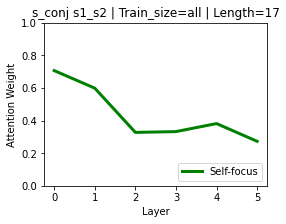

In [1628]:
display_focus_across_layers(self_heads, label='Self-focus', color='green')

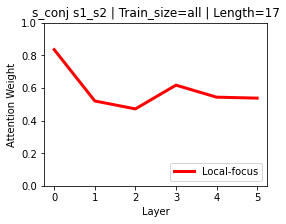

In [1629]:
display_focus_across_layers(local_heads, label='Local-focus', color='red')

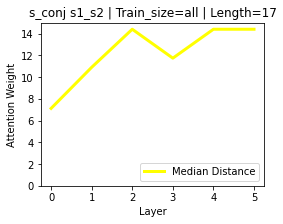

In [1630]:
display_focus_across_layers(distance_weighted_median, label='Median Distance', color='yellow')

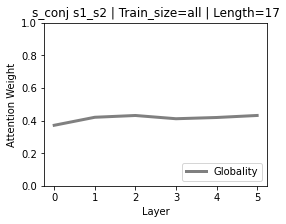

In [1631]:
display_focus_across_layers(globality_scores, label='Globality', color='grey')

In [409]:
# all_gm_scores = []
# all_w_median_scores = []
# for sample_num in range(samples_range[0], samples_range[1]):
#     print(f"sample_num: {sample_num}", end=',')
#     for i in range(NUM_LAYERS):
#         for j in range(NUM_HEADS):
#             gm_score, w_median = display_sample(i, j, sample_num, all_samples, cur_model_path, print_out=False)
#             all_gm_scores.append((gm_score,sample_num,i,j))
#             all_w_median_scores.append((w_median,sample_num,i,j))

# from heapq import nlargest, nsmallest

# def display_multipule_sample(samples_tuple_list):
#     for sample_tuple in samples_tuple_list:
#         display_sample(sample_tuple[2], sample_tuple[3], sample_tuple[1], all_samples, cur_model_path, print_out=True)
#         print("="*120)

# # k_top = 3
# # display_list = [*nsmallest(k_top,all_gm_scores, key=lambda t: t[0]),
# #                 *nsmallest(k_top,all_w_median_scores, key=lambda t: t[0]),
# #                 *nlargest(k_top,all_gm_scores, key=lambda t: t[0]),
# #                 *nlargest(k_top,all_w_median_scores, key=lambda t: t[0])] 

# display_list = [x for x in all_gm_scores if x[0]>=0.0 and x[0] <0.3]

# print(f"Model:{cur_model_path}")
# display_multipule_sample(display_list)

# scores_of_interest = [x for x in all_gm_scores if x[0]>=0.3 and x[0] <0.5]
# sns.heatmap(get_avg_attn_matrix_across_heads(scores_of_interest, cur_model_path, ignore_eos=True))

# plt.hist([x[0] for x in all_w_median_scores], alpha=1.0, label='Weighted Median', histtype='bar')
# plt.legend()

# plt.hist([x[0] for x in all_gm_scores], alpha=0.5, label='Weighted Mean', histtype='bar', color='green')
# plt.legend()

# # - Get the median weighted distance (mwd) 
# # for the eos token attention for every head in every layer,
# # for every sample, plot these values in a scatter plot,
# # plotted against the layer number (so every point would be (mwd, layer number))

# df = pd.DataFrame([(x[0],x[2]) for x in all_w_median_scores], columns=['WMD', 'Layers'])
# sns.catplot(x="Layers", y="WMD", data=df)

NameError: name 'samples_range' is not defined